In [1]:
# !pip uninstall -y fmlc
# !pip install git+https://github.com/LBNL-ETA/FMLC.git
# !pip install statsmodels

In [2]:
import os
import pip
import sys
import copy
import time
import json
import shutil
import random
import numpy as np
import pandas as pd
import datetime as dtm
import matplotlib.pyplot as plt

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 72

try:
    root = os.path.dirname(os.path.abspath(__file__))
except:
    root = os.getcwd()

# Import FMLC
# pip.main(['install', '-q', 'git+https://github.com/LBNL-ETA/FMLC.git'])
# pip.main(['install', '-q', r'/home/Christoph/Documents/PublicRepos/FMLC'])
from fmlc import eFMU, controller_stack, check_error

import fcLib
from fcWrapper import ForecasterWrapper, ForecasterTrainer

### Dummys

In [3]:
import pytz

def example_scada_random(i, external={}):
    # generates a list of SCADA readings with randome SOCs           
    data = {'soc': 99, 'pmax': 1e3, 'emax': 5e3, 
            'echa': 0.96, 'edis': 0.96, 'smin': 0.1, 'smax': 1.0}
    scada1 = pd.DataFrame(index=range(len(data)*3), columns=['name', 'value', 'valid', 'error'])
    ix = 0
    for par, v in data.items():
        for i in range(3):
            
            # overwrite static SOC with random value
            if par == 'soc':
                v = round(random.uniform(0.25, 0.9), 2)
            
            scada1.loc[ix, :] = [f'irn{i}_battery-{par}', v, 1, '']
            ix += 1
            
    for par, v in {'weather-dhi': 0, 'weather-gni': 0, 'weather-ghi': 0, 'weather-rhu': 50,
                   'weather-oat': 20, 'weather-wdi': 0, 'weather-wsp': 0,
                   'irn0_baseload-hi': round(random.uniform(75, 300), 2),
                   'irn0_baseload-low': round(random.uniform(50, 250), 2),
                   'irn0_power-pv': round(random.uniform(0, 150), 2)}.items():
        scada1.loc[len(scada1), :] = [par, v, 1, '']
        
    for par, v in external.items():
        scada1.loc[len(scada1), :] = [par, v, 1, '']
            
    return scada1.to_json()

def example_weather_forecast_random(i, ts):
    wf = pd.read_csv(os.path.join(os.getcwd(), 'example_weatherforecast.csv'), index_col=0)
    # generate random value to scale forecast by
    scaleVal = random.uniform(0.95, 1.05)
    wf *= scaleVal
    wf.index = [pd.to_datetime('2023-01-01')+pd.DateOffset(seconds=i*60*60*ts/60, hours=ii) for ii in range(len(wf))]
    return wf.to_json(), str(wf.index[0])

class getweather_dummy(eFMU):
    def __init__(self):
        self.input = {'ts':None}
        self.output = {'data':None, 'timestamp':None}
        self.i = 0
        self.parksData = None
    def compute(self):
        if True:
            if self.parksData is None:
                parksData = pd.read_csv(pathParks, index_col=0)
                parksData.index = pd.to_datetime(parksData.index)
                self.parksData = parksData               
            # get data
            #fc_st = pd.to_datetime('2019-01-01') + pd.DateOffset(seconds=self.i*60*60*ts/60)
            fc_st = dtm.datetime.fromtimestamp(self.input['time'],
                                               tz=pytz.timezone(tz)).replace(tzinfo=None) # tz from global
            fc_st = fc_st.replace(year=self.parksData.index[100].year) # replace year to align with parks
            fc_ft = fc_st + pd.DateOffset(hours=23)
            data = self.parksData.loc[fc_st:fc_ft, ['temp_air', 'ghi', 'dni', 'dhi']]
            self.output['data'] = data.to_json()
            self.output['timestamp'] = str(data.index[0])
        else:
            self.output['data'], self.output['timestamp'] = example_weather_forecast_random(self.i, self.input['ts'])
        self.i += 1
        return 'Done.'
    
class getscada_dummy(eFMU):
    def __init__(self):
        self.input = {}
        self.output = {'data':None, 'timestamp':None}
        self.i = 0
        self.parksData = None
    def compute(self):
        if True:
            if self.parksData is None:
                parksData = pd.read_csv(pathParks, index_col=0)
                parksData.index = pd.to_datetime(parksData.index)
                self.parksData = parksData               
            # get data
            #fc_st = pd.to_datetime('2019-01-01') + pd.DateOffset(seconds=self.i*60*60*ts/60)
            fc_st = dtm.datetime.fromtimestamp(self.input['time'],
                                               tz=pytz.timezone(tz)).replace(tzinfo=None) # tz from global
            fc_st = fc_st.replace(year=self.parksData.index[100].year) # replace year to align with parks
            data = self.parksData.loc[fc_st, ['1010086328', '1010249061']]
            self.output['data'] = example_scada_random(self.i, external=data.to_dict())
            self.output['timestamp'] = str(data.index[0])
        else:
            self.output['data'] = example_scada_random(self.i)
            self.output['timestamp'] = '2023-01-01 00:00'
        self.i += 1
        return 'Done.'

### move to default config forecasters

In [4]:
from mgc_forecaster import default_parameter_forecaster

### Setup forecasters

In [5]:
# ts = 15 # min
ts = 60 # min
use_fctrainer = True
tz = 'Etc/GMT+8'
pathParks = os.path.join(root, 'resources', 'Camp Parks Data',
                         'training data', 'Parks_2019_training_data_METER_1hr.csv')
log_dir = dtm.datetime.now().strftime('logs_%Y%m%dT%H%M')
os.mkdir(log_dir)

# train_method = 'train_test_split'
train_method = 'daily_split'

In [6]:
# Setup control modules
controller = {}
# Slow loop (5 s sampletime)
controller['getweather'] = {'function': getweather_dummy, 'sampletime': 5} # dummy
controller['getscada'] = {'function': getscada_dummy, 'sampletime': 'getweather'} # dummy
controller['forecastpv'] = {'function': ForecasterWrapper, 'sampletime': 'getscada'}
controller['forecastload'] = {'function': ForecasterWrapper, 'sampletime': 'forecastpv'}
# trainer loop (1 h sampletime)
controller['trainerpv'] = {'function': ForecasterTrainer, 'sampletime': 60*60}
controller['trainerload'] = {'function': ForecasterTrainer, 'sampletime': 'trainerpv'}

# Link control
mapping = {}
# Slow loop

fcList = fcLib.forecaster_list

mapping['getweather_ts'] = ts
mapping['forecastpv_forecaster-list'] = None if use_fctrainer else json.dumps(copy.deepcopy(fcList))
mapping['forecastpv_config'] = default_parameter_forecaster(#targetName='irn0_power-pv',
                                                            targetName='1010086328',
                                                            backupPath='backup_A.csv',
#                                                                    inputPath='backup_A.csv',
                                                            min_days=2,
                                                            horizon=24, # in hours
                                                            stepsize=ts*60,
                                                            train_method=train_method,
                                                            useExternalTrainer=use_fctrainer,
                                                            externalTrainerPath='models_A.pkl',
                                                            trainingInterval=3*24*60*60,
                                                            trainingIntervalBest=24*60*60)
mapping['forecastpv_config']['removeModelsFromPickle'] = False # just for testing
mapping['forecastpv_last-trainall'] = 'trainerpv_last-trainall' if use_fctrainer else None
mapping['forecastpv_weather-data'] = 'getweather_data'
mapping['forecastpv_scada-data'] = 'getscada_data'
mapping['forecastpv_data-timestamp'] = 'getweather_timestamp'
mapping['forecastpv_input-data'] = None
mapping['forecastpv_tz'] = tz
mapping['forecastpv_debug'] = 'info'
mapping['forecastpv_timeout'] = 1e6

mapping['trainerpv_forecaster-list'] = json.dumps(copy.deepcopy(fcList))
trainerpv_config = copy.deepcopy(mapping['forecastpv_config'])
trainerpv_config['backupPath'] = None
trainerpv_config['inputPath'] = 'backup_A.csv'
trainerpv_config['isExternalTrainer'] = True
trainerpv_config['useExternalTrainer'] = False
mapping['trainerpv_config'] = trainerpv_config
mapping['trainerpv_date-trainall'] = 'forecastpv_date-trainall' if use_fctrainer else None
mapping['trainerpv_tz'] = tz
mapping['trainerpv_debug'] = 'info'
mapping['trainerpv_timeout'] = 1e6

mapping['forecastload_forecaster-list'] = None if use_fctrainer else json.dumps(copy.deepcopy(fcList))
mapping['forecastload_config'] = default_parameter_forecaster(#targetName='irn0_baseload-hi',
                                                              targetName='1010249061',
                                                              backupPath='backup_B.csv',
#                                                                      inputPath='backup_B.csv',
                                                              min_days=2,
                                                              horizon=24, # in hours
                                                              stepsize=ts*60,
                                                              train_method=train_method,
                                                              useExternalTrainer=use_fctrainer,
                                                              externalTrainerPath='models_B.pkl',
                                                              trainingInterval=3*24*60*60,
                                                              trainingIntervalBest=24*60*60)
mapping['forecastload_config']['removeModelsFromPickle'] = False # just for testing
mapping['forecastload_last-trainall'] = 'trainerload_last-trainall' if use_fctrainer else None
mapping['forecastload_weather-data'] = 'getweather_data'
mapping['forecastload_scada-data'] = 'getscada_data'
mapping['forecastload_data-timestamp'] = 'getweather_timestamp'
mapping['forecastload_input-data'] = None
mapping['forecastload_tz'] = tz
mapping['forecastload_debug'] = False
mapping['forecastload_timeout'] = 1e6

mapping['trainerload_forecaster-list'] = json.dumps(copy.deepcopy(fcList))
forecastload_config = copy.deepcopy(mapping['forecastload_config'])
forecastload_config['backupPath'] = None
forecastload_config['inputPath'] = 'backup_B.csv'
forecastload_config['isExternalTrainer'] = True
forecastload_config['useExternalTrainer'] = False
mapping['trainerload_config'] = forecastload_config
mapping['trainerload_date-trainall'] = 'forecastload_date-trainall' if use_fctrainer else None
mapping['trainerload_tz'] = tz
mapping['trainerload_debug'] = False
mapping['trainerload_timeout'] = 1e6

# Timeouts
# mapping['forecast_timeout'] = 5

log_config = {'clear_log_period': 1e9, 'dump_log_period': 1e9, 'refresh_period': 1e9,
              'log_path':'./log', 'log_keys': ['input','output','log']}

### Run Forecasters

In [7]:
st = int((pd.to_datetime('2023-01-01') - pd.DateOffset(hours=-8)).value / 1e9)
mgc = controller_stack(controller, mapping, tz=-8, debug=False, name='MGC1',
                       parallel=False, timeout=1e3, log_config=log_config, now=st)
# mgc.run_query_control_for(20, timestep=0.5)

trainingResults = []






st = int((pd.to_datetime('2023-06-01') - pd.DateOffset(hours=-8)).value / 1e9)

# hor = 14*24*60/ts # 14 days



hor = 90*24*60/ts # 90 days



# hor = 150*24*60/ts+2 # 150 days









for i in range(int(hor)):
    print(f'running iteration {i} of {hor}')
    now = st + ts*60*i
    mgc.query_control(now)
    
    if not use_fctrainer:
        if mgc.controller['forecastpv']['fun'].framework.fcData is not None:
            trainingResults.append(mgc.controller['forecastpv']['fun'].framework.fcData.to_json())
            
    # store pkl files
    if mgc.controller['trainerpv']['fun'].output['duration'] > 1:
        now_str = pd.to_datetime(now-8*60*60, unit='s').strftime('%Y%m%dT%H%M')
        shutil.copyfile('models_A.pkl', os.path.join(root, log_dir, f'models_A_{now_str}.pkl'))
        shutil.copyfile('models_B.pkl', os.path.join(root, log_dir, f'models_B_{now_str}.pkl'))
        
        
#     if 'error' in mgc.controller['forecastpv']['fun'].framework.msg.lower():
#         print(errr)
        
log = mgc.log_to_df()
mgc.log_to_csv(path=os.path.join(root, log_dir))
mgc.shutdown()
print('Log-keys:', list(log.keys()))
print('\nLog-messages from "forecastpv')
print(log['forecastpv']['logging'])
print('\nLog-messages from "forecastload')
print(log['forecastload']['logging'])
try:
#     df = pd.read_json(log['controller']['data'].iloc[-1])
#     df['P_batt'] = pd.read_json(log['controller']['control'][-1])
#     df.plot()
    plt.show()
except:
    print('\nNothing to plot.')

running iteration 0 of 2160.0
running iteration 1 of 2160.0
running iteration 2 of 2160.0
running iteration 3 of 2160.0
running iteration 4 of 2160.0
running iteration 5 of 2160.0
running iteration 6 of 2160.0
running iteration 7 of 2160.0
running iteration 8 of 2160.0
running iteration 9 of 2160.0
running iteration 10 of 2160.0
running iteration 11 of 2160.0
running iteration 12 of 2160.0
running iteration 13 of 2160.0
running iteration 14 of 2160.0
running iteration 15 of 2160.0
running iteration 16 of 2160.0
running iteration 17 of 2160.0
running iteration 18 of 2160.0
running iteration 19 of 2160.0
running iteration 20 of 2160.0
running iteration 21 of 2160.0
running iteration 22 of 2160.0
running iteration 23 of 2160.0
running iteration 24 of 2160.0


2023-10-31 03:46:09 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 25 of 2160.0
running iteration 26 of 2160.0
running iteration 27 of 2160.0
running iteration 28 of 2160.0
running iteration 29 of 2160.0
running iteration 30 of 2160.0
running iteration 31 of 2160.0
running iteration 32 of 2160.0
running iteration 33 of 2160.0
running iteration 34 of 2160.0
running iteration 35 of 2160.0
running iteration 36 of 2160.0
running iteration 37 of 2160.0
running iteration 38 of 2160.0
running iteration 39 of 2160.0
running iteration 40 of 2160.0
running iteration 41 of 2160.0
running iteration 42 of 2160.0
running iteration 43 of 2160.0
running iteration 44 of 2160.0
running iteration 45 of 2160.0
running iteration 46 of 2160.0
running iteration 47 of 2160.0


2023-10-31 03:46:11 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 48 of 2160.0
running iteration 49 of 2160.0
running iteration 50 of 2160.0
running iteration 51 of 2160.0
running iteration 52 of 2160.0
running iteration 53 of 2160.0
running iteration 54 of 2160.0
running iteration 55 of 2160.0
running iteration 56 of 2160.0
running iteration 57 of 2160.0
running iteration 58 of 2160.0
running iteration 59 of 2160.0
running iteration 60 of 2160.0
running iteration 61 of 2160.0
running iteration 62 of 2160.0
running iteration 63 of 2160.0
running iteration 64 of 2160.0
running iteration 65 of 2160.0
running iteration 66 of 2160.0
running iteration 67 of 2160.0
running iteration 68 of 2160.0
running iteration 69 of 2160.0
running iteration 70 of 2160.0
running iteration 71 of 2160.0
running iteration 72 of 2160.0
running iteration 73 of 2160.0


2023-10-31 03:46:13 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 74 of 2160.0
running iteration 75 of 2160.0
running iteration 76 of 2160.0
running iteration 77 of 2160.0
running iteration 78 of 2160.0
running iteration 79 of 2160.0
running iteration 80 of 2160.0
running iteration 81 of 2160.0
running iteration 82 of 2160.0
running iteration 83 of 2160.0
running iteration 84 of 2160.0
running iteration 85 of 2160.0
running iteration 86 of 2160.0
running iteration 87 of 2160.0
running iteration 88 of 2160.0
running iteration 89 of 2160.0
running iteration 90 of 2160.0
running iteration 91 of 2160.0
running iteration 92 of 2160.0
running iteration 93 of 2160.0
running iteration 94 of 2160.0


2023-10-31 03:46:15 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)


running iteration 95 of 2160.0
running iteration 96 of 2160.0


2023-10-31 03:46:17 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:46:19 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:46:26 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:46:30 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:47:12 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:47:55 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:48:43 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:48:44 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:48:44 INFO     evaluating model gradient_boosting (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:48:52 INFO     

running iteration 97 of 2160.0
running iteration 98 of 2160.0
running iteration 99 of 2160.0
running iteration 100 of 2160.0
running iteration 101 of 2160.0
running iteration 102 of 2160.0
running iteration 103 of 2160.0
running iteration 104 of 2160.0
running iteration 105 of 2160.0
running iteration 106 of 2160.0
running iteration 107 of 2160.0
running iteration 108 of 2160.0
running iteration 109 of 2160.0
running iteration 110 of 2160.0
running iteration 111 of 2160.0
running iteration 112 of 2160.0
running iteration 113 of 2160.0
running iteration 114 of 2160.0
running iteration 115 of 2160.0
running iteration 116 of 2160.0
running iteration 117 of 2160.0
running iteration 118 of 2160.0
running iteration 119 of 2160.0
running iteration 120 of 2160.0


2023-10-31 03:51:44 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 121 of 2160.0
running iteration 122 of 2160.0
running iteration 123 of 2160.0
running iteration 124 of 2160.0
running iteration 125 of 2160.0
running iteration 126 of 2160.0
running iteration 127 of 2160.0
running iteration 128 of 2160.0
running iteration 129 of 2160.0
running iteration 130 of 2160.0
running iteration 131 of 2160.0
running iteration 132 of 2160.0
running iteration 133 of 2160.0
running iteration 134 of 2160.0
running iteration 135 of 2160.0
running iteration 136 of 2160.0
running iteration 137 of 2160.0
running iteration 138 of 2160.0
running iteration 139 of 2160.0
running iteration 140 of 2160.0
running iteration 141 of 2160.0
running iteration 142 of 2160.0
running iteration 143 of 2160.0
running iteration 144 of 2160.0
running iteration 145 of 2160.0


2023-10-31 03:51:46 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 146 of 2160.0
running iteration 147 of 2160.0
running iteration 148 of 2160.0
running iteration 149 of 2160.0
running iteration 150 of 2160.0
running iteration 151 of 2160.0
running iteration 152 of 2160.0
running iteration 153 of 2160.0
running iteration 154 of 2160.0
running iteration 155 of 2160.0
running iteration 156 of 2160.0
running iteration 157 of 2160.0
running iteration 158 of 2160.0
running iteration 159 of 2160.0
running iteration 160 of 2160.0
running iteration 161 of 2160.0
running iteration 162 of 2160.0
running iteration 163 of 2160.0
running iteration 164 of 2160.0
running iteration 165 of 2160.0
running iteration 166 of 2160.0
running iteration 167 of 2160.0


2023-10-31 03:51:49 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)


running iteration 168 of 2160.0


2023-10-31 03:51:49 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:51:50 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:51:52 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:51:52 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:52:09 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:52:25 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:52:54 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:52:54 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:52:54 INFO     evaluating model gradient_boosting (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:52:57 INFO     

running iteration 169 of 2160.0
running iteration 170 of 2160.0
running iteration 171 of 2160.0
running iteration 172 of 2160.0
running iteration 173 of 2160.0
running iteration 174 of 2160.0
running iteration 175 of 2160.0
running iteration 176 of 2160.0
running iteration 177 of 2160.0
running iteration 178 of 2160.0
running iteration 179 of 2160.0
running iteration 180 of 2160.0
running iteration 181 of 2160.0
running iteration 182 of 2160.0
running iteration 183 of 2160.0
running iteration 184 of 2160.0
running iteration 185 of 2160.0
running iteration 186 of 2160.0
running iteration 187 of 2160.0
running iteration 188 of 2160.0
running iteration 189 of 2160.0
running iteration 190 of 2160.0
running iteration 191 of 2160.0
running iteration 192 of 2160.0


2023-10-31 03:54:09 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 193 of 2160.0
running iteration 194 of 2160.0
running iteration 195 of 2160.0
running iteration 196 of 2160.0
running iteration 197 of 2160.0
running iteration 198 of 2160.0
running iteration 199 of 2160.0
running iteration 200 of 2160.0
running iteration 201 of 2160.0
running iteration 202 of 2160.0
running iteration 203 of 2160.0
running iteration 204 of 2160.0
running iteration 205 of 2160.0
running iteration 206 of 2160.0
running iteration 207 of 2160.0
running iteration 208 of 2160.0
running iteration 209 of 2160.0
running iteration 210 of 2160.0
running iteration 211 of 2160.0
running iteration 212 of 2160.0
running iteration 213 of 2160.0
running iteration 214 of 2160.0
running iteration 215 of 2160.0
running iteration 216 of 2160.0
running iteration 217 of 2160.0


2023-10-31 03:54:13 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 218 of 2160.0
running iteration 219 of 2160.0
running iteration 220 of 2160.0
running iteration 221 of 2160.0
running iteration 222 of 2160.0
running iteration 223 of 2160.0
running iteration 224 of 2160.0
running iteration 225 of 2160.0
running iteration 226 of 2160.0
running iteration 227 of 2160.0
running iteration 228 of 2160.0
running iteration 229 of 2160.0
running iteration 230 of 2160.0
running iteration 231 of 2160.0
running iteration 232 of 2160.0
running iteration 233 of 2160.0
running iteration 234 of 2160.0
running iteration 235 of 2160.0
running iteration 236 of 2160.0
running iteration 237 of 2160.0
running iteration 238 of 2160.0
running iteration 239 of 2160.0
running iteration 240 of 2160.0


2023-10-31 03:54:16 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 03:54:17 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:54:18 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:54:22 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:54:25 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:55:01 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:55:26 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:55:47 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:55:48 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:55:48 INFO     evaluating model gradi

running iteration 241 of 2160.0
running iteration 242 of 2160.0
running iteration 243 of 2160.0
running iteration 244 of 2160.0
running iteration 245 of 2160.0
running iteration 246 of 2160.0
running iteration 247 of 2160.0
running iteration 248 of 2160.0
running iteration 249 of 2160.0
running iteration 250 of 2160.0
running iteration 251 of 2160.0
running iteration 252 of 2160.0
running iteration 253 of 2160.0
running iteration 254 of 2160.0
running iteration 255 of 2160.0
running iteration 256 of 2160.0
running iteration 257 of 2160.0
running iteration 258 of 2160.0
running iteration 259 of 2160.0
running iteration 260 of 2160.0
running iteration 261 of 2160.0
running iteration 262 of 2160.0
running iteration 263 of 2160.0
running iteration 264 of 2160.0


2023-10-31 03:57:50 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 265 of 2160.0
running iteration 266 of 2160.0
running iteration 267 of 2160.0
running iteration 268 of 2160.0
running iteration 269 of 2160.0
running iteration 270 of 2160.0
running iteration 271 of 2160.0
running iteration 272 of 2160.0
running iteration 273 of 2160.0
running iteration 274 of 2160.0
running iteration 275 of 2160.0
running iteration 276 of 2160.0
running iteration 277 of 2160.0
running iteration 278 of 2160.0
running iteration 279 of 2160.0
running iteration 280 of 2160.0
running iteration 281 of 2160.0
running iteration 282 of 2160.0
running iteration 283 of 2160.0
running iteration 284 of 2160.0
running iteration 285 of 2160.0
running iteration 286 of 2160.0
running iteration 287 of 2160.0
running iteration 288 of 2160.0


2023-10-31 03:57:54 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 289 of 2160.0
running iteration 290 of 2160.0
running iteration 291 of 2160.0
running iteration 292 of 2160.0
running iteration 293 of 2160.0
running iteration 294 of 2160.0
running iteration 295 of 2160.0
running iteration 296 of 2160.0
running iteration 297 of 2160.0
running iteration 298 of 2160.0
running iteration 299 of 2160.0
running iteration 300 of 2160.0
running iteration 301 of 2160.0
running iteration 302 of 2160.0
running iteration 303 of 2160.0
running iteration 304 of 2160.0
running iteration 305 of 2160.0
running iteration 306 of 2160.0
running iteration 307 of 2160.0
running iteration 308 of 2160.0
running iteration 309 of 2160.0
running iteration 310 of 2160.0
running iteration 311 of 2160.0
running iteration 312 of 2160.0


2023-10-31 03:57:58 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 03:57:58 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:58:01 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:58:06 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:58:09 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:58:37 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:59:12 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:59:43 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:59:43 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 03:59:44 INFO     evaluating model gradi

running iteration 313 of 2160.0
running iteration 314 of 2160.0
running iteration 315 of 2160.0
running iteration 316 of 2160.0
running iteration 317 of 2160.0
running iteration 318 of 2160.0
running iteration 319 of 2160.0
running iteration 320 of 2160.0
running iteration 321 of 2160.0
running iteration 322 of 2160.0
running iteration 323 of 2160.0
running iteration 324 of 2160.0
running iteration 325 of 2160.0
running iteration 326 of 2160.0
running iteration 327 of 2160.0
running iteration 328 of 2160.0
running iteration 329 of 2160.0
running iteration 330 of 2160.0
running iteration 331 of 2160.0
running iteration 332 of 2160.0
running iteration 333 of 2160.0
running iteration 334 of 2160.0
running iteration 335 of 2160.0


2023-10-31 04:02:23 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 336 of 2160.0
running iteration 337 of 2160.0
running iteration 338 of 2160.0
running iteration 339 of 2160.0
running iteration 340 of 2160.0
running iteration 341 of 2160.0
running iteration 342 of 2160.0
running iteration 343 of 2160.0
running iteration 344 of 2160.0
running iteration 345 of 2160.0
running iteration 346 of 2160.0
running iteration 347 of 2160.0
running iteration 348 of 2160.0
running iteration 349 of 2160.0
running iteration 350 of 2160.0
running iteration 351 of 2160.0
running iteration 352 of 2160.0
running iteration 353 of 2160.0
running iteration 354 of 2160.0
running iteration 355 of 2160.0
running iteration 356 of 2160.0
running iteration 357 of 2160.0
running iteration 358 of 2160.0
running iteration 359 of 2160.0
running iteration 360 of 2160.0


2023-10-31 04:02:26 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 361 of 2160.0
running iteration 362 of 2160.0
running iteration 363 of 2160.0
running iteration 364 of 2160.0
running iteration 365 of 2160.0
running iteration 366 of 2160.0
running iteration 367 of 2160.0
running iteration 368 of 2160.0
running iteration 369 of 2160.0
running iteration 370 of 2160.0
running iteration 371 of 2160.0
running iteration 372 of 2160.0
running iteration 373 of 2160.0
running iteration 374 of 2160.0
running iteration 375 of 2160.0
running iteration 376 of 2160.0
running iteration 377 of 2160.0
running iteration 378 of 2160.0
running iteration 379 of 2160.0
running iteration 380 of 2160.0
running iteration 381 of 2160.0
running iteration 382 of 2160.0
running iteration 383 of 2160.0
running iteration 384 of 2160.0


2023-10-31 04:02:30 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:02:31 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:02:34 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:02:40 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:02:44 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:03:27 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:04:09 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:04:48 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:04:49 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:04:49 INFO     evaluating model gradi

running iteration 385 of 2160.0
running iteration 386 of 2160.0
running iteration 387 of 2160.0
running iteration 388 of 2160.0
running iteration 389 of 2160.0
running iteration 390 of 2160.0
running iteration 391 of 2160.0
running iteration 392 of 2160.0
running iteration 393 of 2160.0
running iteration 394 of 2160.0
running iteration 395 of 2160.0
running iteration 396 of 2160.0
running iteration 397 of 2160.0
running iteration 398 of 2160.0
running iteration 399 of 2160.0
running iteration 400 of 2160.0
running iteration 401 of 2160.0
running iteration 402 of 2160.0
running iteration 403 of 2160.0
running iteration 404 of 2160.0
running iteration 405 of 2160.0
running iteration 406 of 2160.0
running iteration 407 of 2160.0
running iteration 408 of 2160.0


2023-10-31 04:07:41 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 409 of 2160.0
running iteration 410 of 2160.0
running iteration 411 of 2160.0
running iteration 412 of 2160.0
running iteration 413 of 2160.0
running iteration 414 of 2160.0
running iteration 415 of 2160.0
running iteration 416 of 2160.0
running iteration 417 of 2160.0
running iteration 418 of 2160.0
running iteration 419 of 2160.0
running iteration 420 of 2160.0
running iteration 421 of 2160.0
running iteration 422 of 2160.0
running iteration 423 of 2160.0
running iteration 424 of 2160.0
running iteration 425 of 2160.0
running iteration 426 of 2160.0
running iteration 427 of 2160.0
running iteration 428 of 2160.0
running iteration 429 of 2160.0
running iteration 430 of 2160.0
running iteration 431 of 2160.0
running iteration 432 of 2160.0
running iteration 433 of 2160.0


2023-10-31 04:07:44 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 434 of 2160.0
running iteration 435 of 2160.0
running iteration 436 of 2160.0
running iteration 437 of 2160.0
running iteration 438 of 2160.0
running iteration 439 of 2160.0
running iteration 440 of 2160.0
running iteration 441 of 2160.0
running iteration 442 of 2160.0
running iteration 443 of 2160.0
running iteration 444 of 2160.0
running iteration 445 of 2160.0
running iteration 446 of 2160.0
running iteration 447 of 2160.0
running iteration 448 of 2160.0
running iteration 449 of 2160.0
running iteration 450 of 2160.0
running iteration 451 of 2160.0
running iteration 452 of 2160.0
running iteration 453 of 2160.0
running iteration 454 of 2160.0
running iteration 455 of 2160.0
running iteration 456 of 2160.0


2023-10-31 04:07:46 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:07:48 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:07:51 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:08:02 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:08:06 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:08:49 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:09:09 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:09:30 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:09:31 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:09:31 INFO     evaluating model gradi

running iteration 457 of 2160.0
running iteration 458 of 2160.0
running iteration 459 of 2160.0
running iteration 460 of 2160.0
running iteration 461 of 2160.0
running iteration 462 of 2160.0
running iteration 463 of 2160.0
running iteration 464 of 2160.0
running iteration 465 of 2160.0
running iteration 466 of 2160.0
running iteration 467 of 2160.0
running iteration 468 of 2160.0
running iteration 469 of 2160.0
running iteration 470 of 2160.0
running iteration 471 of 2160.0
running iteration 472 of 2160.0
running iteration 473 of 2160.0
running iteration 474 of 2160.0
running iteration 475 of 2160.0
running iteration 476 of 2160.0
running iteration 477 of 2160.0
running iteration 478 of 2160.0
running iteration 479 of 2160.0
running iteration 480 of 2160.0


2023-10-31 04:12:11 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 481 of 2160.0
running iteration 482 of 2160.0
running iteration 483 of 2160.0
running iteration 484 of 2160.0
running iteration 485 of 2160.0
running iteration 486 of 2160.0
running iteration 487 of 2160.0
running iteration 488 of 2160.0
running iteration 489 of 2160.0
running iteration 490 of 2160.0
running iteration 491 of 2160.0
running iteration 492 of 2160.0
running iteration 493 of 2160.0
running iteration 494 of 2160.0
running iteration 495 of 2160.0
running iteration 496 of 2160.0
running iteration 497 of 2160.0
running iteration 498 of 2160.0
running iteration 499 of 2160.0
running iteration 500 of 2160.0
running iteration 501 of 2160.0
running iteration 502 of 2160.0
running iteration 503 of 2160.0
running iteration 504 of 2160.0
running iteration 505 of 2160.0


2023-10-31 04:12:14 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 506 of 2160.0
running iteration 507 of 2160.0
running iteration 508 of 2160.0
running iteration 509 of 2160.0
running iteration 510 of 2160.0
running iteration 511 of 2160.0
running iteration 512 of 2160.0
running iteration 513 of 2160.0
running iteration 514 of 2160.0
running iteration 515 of 2160.0
running iteration 516 of 2160.0
running iteration 517 of 2160.0
running iteration 518 of 2160.0
running iteration 519 of 2160.0
running iteration 520 of 2160.0
running iteration 521 of 2160.0
running iteration 522 of 2160.0
running iteration 523 of 2160.0
running iteration 524 of 2160.0
running iteration 525 of 2160.0
running iteration 526 of 2160.0
running iteration 527 of 2160.0
running iteration 528 of 2160.0


2023-10-31 04:12:17 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:12:18 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:12:23 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:12:35 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:12:42 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:13:26 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:14:02 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:14:36 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:14:37 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:14:38 INFO     evaluating model gradi

running iteration 529 of 2160.0
running iteration 530 of 2160.0
running iteration 531 of 2160.0
running iteration 532 of 2160.0
running iteration 533 of 2160.0
running iteration 534 of 2160.0
running iteration 535 of 2160.0
running iteration 536 of 2160.0
running iteration 537 of 2160.0
running iteration 538 of 2160.0
running iteration 539 of 2160.0
running iteration 540 of 2160.0
running iteration 541 of 2160.0
running iteration 542 of 2160.0
running iteration 543 of 2160.0
running iteration 544 of 2160.0
running iteration 545 of 2160.0
running iteration 546 of 2160.0
running iteration 547 of 2160.0
running iteration 548 of 2160.0
running iteration 549 of 2160.0
running iteration 550 of 2160.0
running iteration 551 of 2160.0
running iteration 552 of 2160.0


2023-10-31 04:17:39 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 553 of 2160.0
running iteration 554 of 2160.0
running iteration 555 of 2160.0
running iteration 556 of 2160.0
running iteration 557 of 2160.0
running iteration 558 of 2160.0
running iteration 559 of 2160.0
running iteration 560 of 2160.0
running iteration 561 of 2160.0
running iteration 562 of 2160.0
running iteration 563 of 2160.0
running iteration 564 of 2160.0
running iteration 565 of 2160.0
running iteration 566 of 2160.0
running iteration 567 of 2160.0
running iteration 568 of 2160.0
running iteration 569 of 2160.0
running iteration 570 of 2160.0
running iteration 571 of 2160.0
running iteration 572 of 2160.0
running iteration 573 of 2160.0
running iteration 574 of 2160.0
running iteration 575 of 2160.0
running iteration 576 of 2160.0
running iteration 577 of 2160.0


2023-10-31 04:17:42 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 578 of 2160.0
running iteration 579 of 2160.0
running iteration 580 of 2160.0
running iteration 581 of 2160.0
running iteration 582 of 2160.0
running iteration 583 of 2160.0
running iteration 584 of 2160.0
running iteration 585 of 2160.0
running iteration 586 of 2160.0
running iteration 587 of 2160.0
running iteration 588 of 2160.0
running iteration 589 of 2160.0
running iteration 590 of 2160.0
running iteration 591 of 2160.0
running iteration 592 of 2160.0
running iteration 593 of 2160.0
running iteration 594 of 2160.0
running iteration 595 of 2160.0
running iteration 596 of 2160.0
running iteration 597 of 2160.0
running iteration 598 of 2160.0
running iteration 599 of 2160.0
running iteration 600 of 2160.0


2023-10-31 04:17:44 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:17:46 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:17:52 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:18:07 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:18:14 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:18:54 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:19:29 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:20:10 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:20:11 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:20:12 INFO     evaluating model gradi

running iteration 601 of 2160.0
running iteration 602 of 2160.0
running iteration 603 of 2160.0
running iteration 604 of 2160.0
running iteration 605 of 2160.0
running iteration 606 of 2160.0
running iteration 607 of 2160.0
running iteration 608 of 2160.0
running iteration 609 of 2160.0
running iteration 610 of 2160.0
running iteration 611 of 2160.0
running iteration 612 of 2160.0
running iteration 613 of 2160.0
running iteration 614 of 2160.0
running iteration 615 of 2160.0
running iteration 616 of 2160.0
running iteration 617 of 2160.0
running iteration 618 of 2160.0
running iteration 619 of 2160.0
running iteration 620 of 2160.0
running iteration 621 of 2160.0
running iteration 622 of 2160.0
running iteration 623 of 2160.0
running iteration 624 of 2160.0


2023-10-31 04:23:41 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 625 of 2160.0
running iteration 626 of 2160.0
running iteration 627 of 2160.0
running iteration 628 of 2160.0
running iteration 629 of 2160.0
running iteration 630 of 2160.0
running iteration 631 of 2160.0
running iteration 632 of 2160.0
running iteration 633 of 2160.0
running iteration 634 of 2160.0
running iteration 635 of 2160.0
running iteration 636 of 2160.0
running iteration 637 of 2160.0
running iteration 638 of 2160.0
running iteration 639 of 2160.0
running iteration 640 of 2160.0
running iteration 641 of 2160.0
running iteration 642 of 2160.0
running iteration 643 of 2160.0
running iteration 644 of 2160.0
running iteration 645 of 2160.0
running iteration 646 of 2160.0
running iteration 647 of 2160.0
running iteration 648 of 2160.0


2023-10-31 04:23:44 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 649 of 2160.0
running iteration 650 of 2160.0
running iteration 651 of 2160.0
running iteration 652 of 2160.0
running iteration 653 of 2160.0
running iteration 654 of 2160.0
running iteration 655 of 2160.0
running iteration 656 of 2160.0
running iteration 657 of 2160.0
running iteration 658 of 2160.0
running iteration 659 of 2160.0
running iteration 660 of 2160.0
running iteration 661 of 2160.0
running iteration 662 of 2160.0
running iteration 663 of 2160.0
running iteration 664 of 2160.0
running iteration 665 of 2160.0
running iteration 666 of 2160.0
running iteration 667 of 2160.0
running iteration 668 of 2160.0
running iteration 669 of 2160.0
running iteration 670 of 2160.0
running iteration 671 of 2160.0
running iteration 672 of 2160.0


2023-10-31 04:23:47 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:23:49 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:23:56 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:24:13 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:24:22 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:24:32 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:24:40 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:24:57 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:24:58 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:24:59 INFO     evaluating model gradi

running iteration 673 of 2160.0
running iteration 674 of 2160.0
running iteration 675 of 2160.0
running iteration 676 of 2160.0
running iteration 677 of 2160.0
running iteration 678 of 2160.0
running iteration 679 of 2160.0
running iteration 680 of 2160.0
running iteration 681 of 2160.0
running iteration 682 of 2160.0
running iteration 683 of 2160.0
running iteration 684 of 2160.0
running iteration 685 of 2160.0
running iteration 686 of 2160.0
running iteration 687 of 2160.0
running iteration 688 of 2160.0
running iteration 689 of 2160.0
running iteration 690 of 2160.0
running iteration 691 of 2160.0
running iteration 692 of 2160.0
running iteration 693 of 2160.0
running iteration 694 of 2160.0
running iteration 695 of 2160.0


2023-10-31 04:27:32 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 696 of 2160.0
running iteration 697 of 2160.0
running iteration 698 of 2160.0
running iteration 699 of 2160.0
running iteration 700 of 2160.0
running iteration 701 of 2160.0
running iteration 702 of 2160.0
running iteration 703 of 2160.0
running iteration 704 of 2160.0
running iteration 705 of 2160.0
running iteration 706 of 2160.0
running iteration 707 of 2160.0
running iteration 708 of 2160.0
running iteration 709 of 2160.0
running iteration 710 of 2160.0
running iteration 711 of 2160.0
running iteration 712 of 2160.0
running iteration 713 of 2160.0
running iteration 714 of 2160.0
running iteration 715 of 2160.0
running iteration 716 of 2160.0
running iteration 717 of 2160.0
running iteration 718 of 2160.0
running iteration 719 of 2160.0
running iteration 720 of 2160.0
running iteration 721 of 2160.0


2023-10-31 04:27:35 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 722 of 2160.0
running iteration 723 of 2160.0
running iteration 724 of 2160.0
running iteration 725 of 2160.0
running iteration 726 of 2160.0
running iteration 727 of 2160.0
running iteration 728 of 2160.0
running iteration 729 of 2160.0
running iteration 730 of 2160.0
running iteration 731 of 2160.0
running iteration 732 of 2160.0
running iteration 733 of 2160.0
running iteration 734 of 2160.0
running iteration 735 of 2160.0
running iteration 736 of 2160.0
running iteration 737 of 2160.0
running iteration 738 of 2160.0
running iteration 739 of 2160.0
running iteration 740 of 2160.0
running iteration 741 of 2160.0
running iteration 742 of 2160.0
running iteration 743 of 2160.0
running iteration 744 of 2160.0


2023-10-31 04:27:38 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:27:41 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:27:49 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:28:10 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:28:18 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:28:53 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:29:26 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:29:57 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:29:59 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:30:00 INFO     evaluating model gradi

running iteration 745 of 2160.0
running iteration 746 of 2160.0
running iteration 747 of 2160.0
running iteration 748 of 2160.0
running iteration 749 of 2160.0
running iteration 750 of 2160.0
running iteration 751 of 2160.0
running iteration 752 of 2160.0
running iteration 753 of 2160.0
running iteration 754 of 2160.0
running iteration 755 of 2160.0
running iteration 756 of 2160.0
running iteration 757 of 2160.0
running iteration 758 of 2160.0
running iteration 759 of 2160.0
running iteration 760 of 2160.0
running iteration 761 of 2160.0
running iteration 762 of 2160.0
running iteration 763 of 2160.0
running iteration 764 of 2160.0
running iteration 765 of 2160.0
running iteration 766 of 2160.0
running iteration 767 of 2160.0
running iteration 768 of 2160.0


2023-10-31 04:33:50 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 769 of 2160.0
running iteration 770 of 2160.0
running iteration 771 of 2160.0
running iteration 772 of 2160.0
running iteration 773 of 2160.0
running iteration 774 of 2160.0
running iteration 775 of 2160.0
running iteration 776 of 2160.0
running iteration 777 of 2160.0
running iteration 778 of 2160.0
running iteration 779 of 2160.0
running iteration 780 of 2160.0
running iteration 781 of 2160.0
running iteration 782 of 2160.0
running iteration 783 of 2160.0
running iteration 784 of 2160.0
running iteration 785 of 2160.0
running iteration 786 of 2160.0
running iteration 787 of 2160.0
running iteration 788 of 2160.0
running iteration 789 of 2160.0
running iteration 790 of 2160.0
running iteration 791 of 2160.0
running iteration 792 of 2160.0
running iteration 793 of 2160.0


2023-10-31 04:33:53 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 794 of 2160.0
running iteration 795 of 2160.0
running iteration 796 of 2160.0
running iteration 797 of 2160.0
running iteration 798 of 2160.0
running iteration 799 of 2160.0
running iteration 800 of 2160.0
running iteration 801 of 2160.0
running iteration 802 of 2160.0
running iteration 803 of 2160.0
running iteration 804 of 2160.0
running iteration 805 of 2160.0
running iteration 806 of 2160.0
running iteration 807 of 2160.0
running iteration 808 of 2160.0
running iteration 809 of 2160.0
running iteration 810 of 2160.0
running iteration 811 of 2160.0
running iteration 812 of 2160.0
running iteration 813 of 2160.0
running iteration 814 of 2160.0
running iteration 815 of 2160.0
running iteration 816 of 2160.0


2023-10-31 04:33:57 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:33:59 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:34:09 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:34:33 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:34:46 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:35:26 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:35:59 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:36:43 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:36:45 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:36:46 INFO     evaluating model gradi

running iteration 817 of 2160.0
running iteration 818 of 2160.0
running iteration 819 of 2160.0
running iteration 820 of 2160.0
running iteration 821 of 2160.0
running iteration 822 of 2160.0
running iteration 823 of 2160.0
running iteration 824 of 2160.0
running iteration 825 of 2160.0
running iteration 826 of 2160.0
running iteration 827 of 2160.0
running iteration 828 of 2160.0
running iteration 829 of 2160.0
running iteration 830 of 2160.0
running iteration 831 of 2160.0
running iteration 832 of 2160.0
running iteration 833 of 2160.0
running iteration 834 of 2160.0
running iteration 835 of 2160.0
running iteration 836 of 2160.0
running iteration 837 of 2160.0
running iteration 838 of 2160.0
running iteration 839 of 2160.0
running iteration 840 of 2160.0


2023-10-31 04:40:53 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 841 of 2160.0
running iteration 842 of 2160.0
running iteration 843 of 2160.0
running iteration 844 of 2160.0
running iteration 845 of 2160.0
running iteration 846 of 2160.0
running iteration 847 of 2160.0
running iteration 848 of 2160.0
running iteration 849 of 2160.0
running iteration 850 of 2160.0
running iteration 851 of 2160.0
running iteration 852 of 2160.0
running iteration 853 of 2160.0
running iteration 854 of 2160.0
running iteration 855 of 2160.0
running iteration 856 of 2160.0
running iteration 857 of 2160.0
running iteration 858 of 2160.0
running iteration 859 of 2160.0
running iteration 860 of 2160.0
running iteration 861 of 2160.0
running iteration 862 of 2160.0
running iteration 863 of 2160.0
running iteration 864 of 2160.0


2023-10-31 04:40:56 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 865 of 2160.0
running iteration 866 of 2160.0
running iteration 867 of 2160.0
running iteration 868 of 2160.0
running iteration 869 of 2160.0
running iteration 870 of 2160.0
running iteration 871 of 2160.0
running iteration 872 of 2160.0
running iteration 873 of 2160.0
running iteration 874 of 2160.0
running iteration 875 of 2160.0
running iteration 876 of 2160.0
running iteration 877 of 2160.0
running iteration 878 of 2160.0
running iteration 879 of 2160.0
running iteration 880 of 2160.0
running iteration 881 of 2160.0
running iteration 882 of 2160.0
running iteration 883 of 2160.0
running iteration 884 of 2160.0
running iteration 885 of 2160.0
running iteration 886 of 2160.0
running iteration 887 of 2160.0
running iteration 888 of 2160.0


2023-10-31 04:40:59 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:41:02 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:41:12 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:41:38 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:41:49 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:42:34 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:43:06 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:43:41 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:43:43 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:43:44 INFO     evaluating model gradi

running iteration 889 of 2160.0
running iteration 890 of 2160.0
running iteration 891 of 2160.0
running iteration 892 of 2160.0
running iteration 893 of 2160.0
running iteration 894 of 2160.0
running iteration 895 of 2160.0
running iteration 896 of 2160.0
running iteration 897 of 2160.0
running iteration 898 of 2160.0
running iteration 899 of 2160.0
running iteration 900 of 2160.0
running iteration 901 of 2160.0
running iteration 902 of 2160.0
running iteration 903 of 2160.0
running iteration 904 of 2160.0
running iteration 905 of 2160.0
running iteration 906 of 2160.0
running iteration 907 of 2160.0
running iteration 908 of 2160.0
running iteration 909 of 2160.0
running iteration 910 of 2160.0
running iteration 911 of 2160.0


2023-10-31 04:49:08 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 912 of 2160.0
running iteration 913 of 2160.0
running iteration 914 of 2160.0
running iteration 915 of 2160.0
running iteration 916 of 2160.0
running iteration 917 of 2160.0
running iteration 918 of 2160.0
running iteration 919 of 2160.0
running iteration 920 of 2160.0
running iteration 921 of 2160.0
running iteration 922 of 2160.0
running iteration 923 of 2160.0
running iteration 924 of 2160.0
running iteration 925 of 2160.0
running iteration 926 of 2160.0
running iteration 927 of 2160.0
running iteration 928 of 2160.0
running iteration 929 of 2160.0
running iteration 930 of 2160.0
running iteration 931 of 2160.0
running iteration 932 of 2160.0
running iteration 933 of 2160.0
running iteration 934 of 2160.0
running iteration 935 of 2160.0
running iteration 936 of 2160.0
running iteration 937 of 2160.0


2023-10-31 04:49:11 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 938 of 2160.0
running iteration 939 of 2160.0
running iteration 940 of 2160.0
running iteration 941 of 2160.0
running iteration 942 of 2160.0
running iteration 943 of 2160.0
running iteration 944 of 2160.0
running iteration 945 of 2160.0
running iteration 946 of 2160.0
running iteration 947 of 2160.0
running iteration 948 of 2160.0
running iteration 949 of 2160.0
running iteration 950 of 2160.0
running iteration 951 of 2160.0
running iteration 952 of 2160.0
running iteration 953 of 2160.0
running iteration 954 of 2160.0
running iteration 955 of 2160.0
running iteration 956 of 2160.0
running iteration 957 of 2160.0
running iteration 958 of 2160.0
running iteration 959 of 2160.0
running iteration 960 of 2160.0


2023-10-31 04:49:15 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:49:18 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:49:29 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:49:59 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:50:10 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:50:35 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:51:04 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:51:25 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:51:28 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:51:29 INFO     evaluating model gradi

running iteration 961 of 2160.0
running iteration 962 of 2160.0
running iteration 963 of 2160.0
running iteration 964 of 2160.0
running iteration 965 of 2160.0
running iteration 966 of 2160.0
running iteration 967 of 2160.0
running iteration 968 of 2160.0
running iteration 969 of 2160.0
running iteration 970 of 2160.0
running iteration 971 of 2160.0
running iteration 972 of 2160.0
running iteration 973 of 2160.0
running iteration 974 of 2160.0
running iteration 975 of 2160.0
running iteration 976 of 2160.0
running iteration 977 of 2160.0
running iteration 978 of 2160.0
running iteration 979 of 2160.0
running iteration 980 of 2160.0
running iteration 981 of 2160.0
running iteration 982 of 2160.0
running iteration 983 of 2160.0


2023-10-31 04:56:03 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 984 of 2160.0
running iteration 985 of 2160.0
running iteration 986 of 2160.0
running iteration 987 of 2160.0
running iteration 988 of 2160.0
running iteration 989 of 2160.0
running iteration 990 of 2160.0
running iteration 991 of 2160.0
running iteration 992 of 2160.0
running iteration 993 of 2160.0
running iteration 994 of 2160.0
running iteration 995 of 2160.0
running iteration 996 of 2160.0
running iteration 997 of 2160.0
running iteration 998 of 2160.0
running iteration 999 of 2160.0
running iteration 1000 of 2160.0
running iteration 1001 of 2160.0
running iteration 1002 of 2160.0
running iteration 1003 of 2160.0
running iteration 1004 of 2160.0
running iteration 1005 of 2160.0
running iteration 1006 of 2160.0
running iteration 1007 of 2160.0
running iteration 1008 of 2160.0
running iteration 1009 of 2160.0


2023-10-31 04:56:07 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1010 of 2160.0
running iteration 1011 of 2160.0
running iteration 1012 of 2160.0
running iteration 1013 of 2160.0
running iteration 1014 of 2160.0
running iteration 1015 of 2160.0
running iteration 1016 of 2160.0
running iteration 1017 of 2160.0
running iteration 1018 of 2160.0
running iteration 1019 of 2160.0
running iteration 1020 of 2160.0
running iteration 1021 of 2160.0
running iteration 1022 of 2160.0
running iteration 1023 of 2160.0
running iteration 1024 of 2160.0
running iteration 1025 of 2160.0
running iteration 1026 of 2160.0
running iteration 1027 of 2160.0
running iteration 1028 of 2160.0
running iteration 1029 of 2160.0
running iteration 1030 of 2160.0
running iteration 1031 of 2160.0
running iteration 1032 of 2160.0


2023-10-31 04:56:10 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 04:56:14 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:56:28 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:57:03 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:57:19 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:58:08 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:58:42 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:59:28 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:59:31 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 04:59:32 INFO     evaluating model gradi

running iteration 1033 of 2160.0
running iteration 1034 of 2160.0
running iteration 1035 of 2160.0
running iteration 1036 of 2160.0
running iteration 1037 of 2160.0
running iteration 1038 of 2160.0
running iteration 1039 of 2160.0
running iteration 1040 of 2160.0
running iteration 1041 of 2160.0
running iteration 1042 of 2160.0
running iteration 1043 of 2160.0
running iteration 1044 of 2160.0
running iteration 1045 of 2160.0
running iteration 1046 of 2160.0
running iteration 1047 of 2160.0
running iteration 1048 of 2160.0
running iteration 1049 of 2160.0
running iteration 1050 of 2160.0
running iteration 1051 of 2160.0
running iteration 1052 of 2160.0
running iteration 1053 of 2160.0
running iteration 1054 of 2160.0
running iteration 1055 of 2160.0
running iteration 1056 of 2160.0


2023-10-31 05:05:25 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1057 of 2160.0
running iteration 1058 of 2160.0
running iteration 1059 of 2160.0
running iteration 1060 of 2160.0
running iteration 1061 of 2160.0
running iteration 1062 of 2160.0
running iteration 1063 of 2160.0
running iteration 1064 of 2160.0
running iteration 1065 of 2160.0
running iteration 1066 of 2160.0
running iteration 1067 of 2160.0
running iteration 1068 of 2160.0
running iteration 1069 of 2160.0
running iteration 1070 of 2160.0
running iteration 1071 of 2160.0
running iteration 1072 of 2160.0
running iteration 1073 of 2160.0
running iteration 1074 of 2160.0
running iteration 1075 of 2160.0
running iteration 1076 of 2160.0
running iteration 1077 of 2160.0
running iteration 1078 of 2160.0
running iteration 1079 of 2160.0
running iteration 1080 of 2160.0
running iteration 1081 of 2160.0


2023-10-31 05:05:29 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1082 of 2160.0
running iteration 1083 of 2160.0
running iteration 1084 of 2160.0
running iteration 1085 of 2160.0
running iteration 1086 of 2160.0
running iteration 1087 of 2160.0
running iteration 1088 of 2160.0
running iteration 1089 of 2160.0
running iteration 1090 of 2160.0
running iteration 1091 of 2160.0
running iteration 1092 of 2160.0
running iteration 1093 of 2160.0
running iteration 1094 of 2160.0
running iteration 1095 of 2160.0
running iteration 1096 of 2160.0
running iteration 1097 of 2160.0
running iteration 1098 of 2160.0
running iteration 1099 of 2160.0
running iteration 1100 of 2160.0
running iteration 1101 of 2160.0
running iteration 1102 of 2160.0
running iteration 1103 of 2160.0
running iteration 1104 of 2160.0


2023-10-31 05:05:33 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 05:05:36 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:05:51 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:06:29 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:06:45 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:07:24 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:08:13 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:09:02 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:09:05 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:09:07 INFO     evaluating model gradi

running iteration 1105 of 2160.0
running iteration 1106 of 2160.0
running iteration 1107 of 2160.0
running iteration 1108 of 2160.0
running iteration 1109 of 2160.0
running iteration 1110 of 2160.0
running iteration 1111 of 2160.0
running iteration 1112 of 2160.0
running iteration 1113 of 2160.0
running iteration 1114 of 2160.0
running iteration 1115 of 2160.0
running iteration 1116 of 2160.0
running iteration 1117 of 2160.0
running iteration 1118 of 2160.0
running iteration 1119 of 2160.0
running iteration 1120 of 2160.0
running iteration 1121 of 2160.0
running iteration 1122 of 2160.0
running iteration 1123 of 2160.0
running iteration 1124 of 2160.0
running iteration 1125 of 2160.0
running iteration 1126 of 2160.0
running iteration 1127 of 2160.0
running iteration 1128 of 2160.0


2023-10-31 05:15:00 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1129 of 2160.0
running iteration 1130 of 2160.0
running iteration 1131 of 2160.0
running iteration 1132 of 2160.0
running iteration 1133 of 2160.0
running iteration 1134 of 2160.0
running iteration 1135 of 2160.0
running iteration 1136 of 2160.0
running iteration 1137 of 2160.0
running iteration 1138 of 2160.0
running iteration 1139 of 2160.0
running iteration 1140 of 2160.0
running iteration 1141 of 2160.0
running iteration 1142 of 2160.0
running iteration 1143 of 2160.0
running iteration 1144 of 2160.0
running iteration 1145 of 2160.0
running iteration 1146 of 2160.0
running iteration 1147 of 2160.0
running iteration 1148 of 2160.0
running iteration 1149 of 2160.0
running iteration 1150 of 2160.0
running iteration 1151 of 2160.0
running iteration 1152 of 2160.0


2023-10-31 05:15:04 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1153 of 2160.0
running iteration 1154 of 2160.0
running iteration 1155 of 2160.0
running iteration 1156 of 2160.0
running iteration 1157 of 2160.0
running iteration 1158 of 2160.0
running iteration 1159 of 2160.0
running iteration 1160 of 2160.0
running iteration 1161 of 2160.0
running iteration 1162 of 2160.0
running iteration 1163 of 2160.0
running iteration 1164 of 2160.0
running iteration 1165 of 2160.0
running iteration 1166 of 2160.0
running iteration 1167 of 2160.0
running iteration 1168 of 2160.0
running iteration 1169 of 2160.0
running iteration 1170 of 2160.0
running iteration 1171 of 2160.0
running iteration 1172 of 2160.0
running iteration 1173 of 2160.0
running iteration 1174 of 2160.0
running iteration 1175 of 2160.0
running iteration 1176 of 2160.0


2023-10-31 05:15:08 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 05:15:12 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:15:27 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:16:07 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:16:25 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:17:19 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:18:10 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:19:04 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:19:08 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:19:09 INFO     evaluating model gradi

running iteration 1177 of 2160.0
running iteration 1178 of 2160.0
running iteration 1179 of 2160.0
running iteration 1180 of 2160.0
running iteration 1181 of 2160.0
running iteration 1182 of 2160.0
running iteration 1183 of 2160.0
running iteration 1184 of 2160.0
running iteration 1185 of 2160.0
running iteration 1186 of 2160.0
running iteration 1187 of 2160.0
running iteration 1188 of 2160.0
running iteration 1189 of 2160.0
running iteration 1190 of 2160.0
running iteration 1191 of 2160.0
running iteration 1192 of 2160.0
running iteration 1193 of 2160.0
running iteration 1194 of 2160.0
running iteration 1195 of 2160.0
running iteration 1196 of 2160.0
running iteration 1197 of 2160.0
running iteration 1198 of 2160.0
running iteration 1199 of 2160.0


2023-10-31 05:25:10 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1200 of 2160.0
running iteration 1201 of 2160.0
running iteration 1202 of 2160.0
running iteration 1203 of 2160.0
running iteration 1204 of 2160.0
running iteration 1205 of 2160.0
running iteration 1206 of 2160.0
running iteration 1207 of 2160.0
running iteration 1208 of 2160.0
running iteration 1209 of 2160.0
running iteration 1210 of 2160.0
running iteration 1211 of 2160.0
running iteration 1212 of 2160.0
running iteration 1213 of 2160.0
running iteration 1214 of 2160.0
running iteration 1215 of 2160.0
running iteration 1216 of 2160.0
running iteration 1217 of 2160.0
running iteration 1218 of 2160.0
running iteration 1219 of 2160.0
running iteration 1220 of 2160.0
running iteration 1221 of 2160.0
running iteration 1222 of 2160.0
running iteration 1223 of 2160.0
running iteration 1224 of 2160.0
running iteration 1225 of 2160.0


2023-10-31 05:25:13 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1226 of 2160.0
running iteration 1227 of 2160.0
running iteration 1228 of 2160.0
running iteration 1229 of 2160.0
running iteration 1230 of 2160.0
running iteration 1231 of 2160.0
running iteration 1232 of 2160.0
running iteration 1233 of 2160.0
running iteration 1234 of 2160.0
running iteration 1235 of 2160.0
running iteration 1236 of 2160.0
running iteration 1237 of 2160.0
running iteration 1238 of 2160.0
running iteration 1239 of 2160.0
running iteration 1240 of 2160.0
running iteration 1241 of 2160.0
running iteration 1242 of 2160.0
running iteration 1243 of 2160.0
running iteration 1244 of 2160.0
running iteration 1245 of 2160.0
running iteration 1246 of 2160.0
running iteration 1247 of 2160.0
running iteration 1248 of 2160.0


2023-10-31 05:25:17 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 05:25:22 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:25:38 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:26:23 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:26:41 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:27:22 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:27:58 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:28:39 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:28:42 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:28:44 INFO     evaluating model gradi

running iteration 1249 of 2160.0
running iteration 1250 of 2160.0
running iteration 1251 of 2160.0
running iteration 1252 of 2160.0
running iteration 1253 of 2160.0
running iteration 1254 of 2160.0
running iteration 1255 of 2160.0
running iteration 1256 of 2160.0
running iteration 1257 of 2160.0
running iteration 1258 of 2160.0
running iteration 1259 of 2160.0
running iteration 1260 of 2160.0
running iteration 1261 of 2160.0
running iteration 1262 of 2160.0
running iteration 1263 of 2160.0
running iteration 1264 of 2160.0
running iteration 1265 of 2160.0
running iteration 1266 of 2160.0
running iteration 1267 of 2160.0
running iteration 1268 of 2160.0
running iteration 1269 of 2160.0
running iteration 1270 of 2160.0
running iteration 1271 of 2160.0
running iteration 1272 of 2160.0


2023-10-31 05:35:13 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1273 of 2160.0
running iteration 1274 of 2160.0
running iteration 1275 of 2160.0
running iteration 1276 of 2160.0
running iteration 1277 of 2160.0
running iteration 1278 of 2160.0
running iteration 1279 of 2160.0
running iteration 1280 of 2160.0
running iteration 1281 of 2160.0
running iteration 1282 of 2160.0
running iteration 1283 of 2160.0
running iteration 1284 of 2160.0
running iteration 1285 of 2160.0
running iteration 1286 of 2160.0
running iteration 1287 of 2160.0
running iteration 1288 of 2160.0
running iteration 1289 of 2160.0
running iteration 1290 of 2160.0
running iteration 1291 of 2160.0
running iteration 1292 of 2160.0
running iteration 1293 of 2160.0
running iteration 1294 of 2160.0
running iteration 1295 of 2160.0
running iteration 1296 of 2160.0
running iteration 1297 of 2160.0


2023-10-31 05:35:17 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1298 of 2160.0
running iteration 1299 of 2160.0
running iteration 1300 of 2160.0
running iteration 1301 of 2160.0
running iteration 1302 of 2160.0
running iteration 1303 of 2160.0
running iteration 1304 of 2160.0
running iteration 1305 of 2160.0
running iteration 1306 of 2160.0
running iteration 1307 of 2160.0
running iteration 1308 of 2160.0
running iteration 1309 of 2160.0
running iteration 1310 of 2160.0
running iteration 1311 of 2160.0
running iteration 1312 of 2160.0
running iteration 1313 of 2160.0
running iteration 1314 of 2160.0
running iteration 1315 of 2160.0
running iteration 1316 of 2160.0
running iteration 1317 of 2160.0
running iteration 1318 of 2160.0
running iteration 1319 of 2160.0
running iteration 1320 of 2160.0


2023-10-31 05:35:21 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 05:35:26 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:35:43 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:36:31 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:36:52 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:37:36 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:38:28 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:39:31 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:39:35 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:39:36 INFO     evaluating model gradi

running iteration 1321 of 2160.0
running iteration 1322 of 2160.0
running iteration 1323 of 2160.0
running iteration 1324 of 2160.0
running iteration 1325 of 2160.0
running iteration 1326 of 2160.0
running iteration 1327 of 2160.0
running iteration 1328 of 2160.0
running iteration 1329 of 2160.0
running iteration 1330 of 2160.0
running iteration 1331 of 2160.0
running iteration 1332 of 2160.0
running iteration 1333 of 2160.0
running iteration 1334 of 2160.0
running iteration 1335 of 2160.0
running iteration 1336 of 2160.0
running iteration 1337 of 2160.0
running iteration 1338 of 2160.0
running iteration 1339 of 2160.0
running iteration 1340 of 2160.0
running iteration 1341 of 2160.0
running iteration 1342 of 2160.0
running iteration 1343 of 2160.0
running iteration 1344 of 2160.0
running iteration 1345 of 2160.0


2023-10-31 05:47:03 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1346 of 2160.0
running iteration 1347 of 2160.0
running iteration 1348 of 2160.0
running iteration 1349 of 2160.0
running iteration 1350 of 2160.0
running iteration 1351 of 2160.0
running iteration 1352 of 2160.0
running iteration 1353 of 2160.0
running iteration 1354 of 2160.0
running iteration 1355 of 2160.0
running iteration 1356 of 2160.0
running iteration 1357 of 2160.0
running iteration 1358 of 2160.0
running iteration 1359 of 2160.0
running iteration 1360 of 2160.0
running iteration 1361 of 2160.0
running iteration 1362 of 2160.0
running iteration 1363 of 2160.0
running iteration 1364 of 2160.0
running iteration 1365 of 2160.0
running iteration 1366 of 2160.0
running iteration 1367 of 2160.0
running iteration 1368 of 2160.0


2023-10-31 05:47:06 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1369 of 2160.0
running iteration 1370 of 2160.0
running iteration 1371 of 2160.0
running iteration 1372 of 2160.0
running iteration 1373 of 2160.0
running iteration 1374 of 2160.0
running iteration 1375 of 2160.0
running iteration 1376 of 2160.0
running iteration 1377 of 2160.0
running iteration 1378 of 2160.0
running iteration 1379 of 2160.0
running iteration 1380 of 2160.0
running iteration 1381 of 2160.0
running iteration 1382 of 2160.0
running iteration 1383 of 2160.0
running iteration 1384 of 2160.0
running iteration 1385 of 2160.0
running iteration 1386 of 2160.0
running iteration 1387 of 2160.0
running iteration 1388 of 2160.0
running iteration 1389 of 2160.0
running iteration 1390 of 2160.0
running iteration 1391 of 2160.0
running iteration 1392 of 2160.0


2023-10-31 05:47:09 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 05:47:14 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:47:32 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:48:22 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:48:43 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:49:17 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:50:14 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:51:12 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:51:17 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:51:18 INFO     evaluating model gradi

running iteration 1393 of 2160.0
running iteration 1394 of 2160.0
running iteration 1395 of 2160.0
running iteration 1396 of 2160.0
running iteration 1397 of 2160.0
running iteration 1398 of 2160.0
running iteration 1399 of 2160.0
running iteration 1400 of 2160.0
running iteration 1401 of 2160.0
running iteration 1402 of 2160.0
running iteration 1403 of 2160.0
running iteration 1404 of 2160.0
running iteration 1405 of 2160.0
running iteration 1406 of 2160.0
running iteration 1407 of 2160.0
running iteration 1408 of 2160.0
running iteration 1409 of 2160.0
running iteration 1410 of 2160.0
running iteration 1411 of 2160.0
running iteration 1412 of 2160.0
running iteration 1413 of 2160.0
running iteration 1414 of 2160.0
running iteration 1415 of 2160.0


2023-10-31 05:59:12 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1416 of 2160.0
running iteration 1417 of 2160.0
running iteration 1418 of 2160.0
running iteration 1419 of 2160.0
running iteration 1420 of 2160.0
running iteration 1421 of 2160.0
running iteration 1422 of 2160.0
running iteration 1423 of 2160.0
running iteration 1424 of 2160.0
running iteration 1425 of 2160.0
running iteration 1426 of 2160.0
running iteration 1427 of 2160.0
running iteration 1428 of 2160.0
running iteration 1429 of 2160.0
running iteration 1430 of 2160.0
running iteration 1431 of 2160.0
running iteration 1432 of 2160.0
running iteration 1433 of 2160.0
running iteration 1434 of 2160.0
running iteration 1435 of 2160.0
running iteration 1436 of 2160.0
running iteration 1437 of 2160.0
running iteration 1438 of 2160.0
running iteration 1439 of 2160.0
running iteration 1440 of 2160.0


2023-10-31 05:59:15 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1441 of 2160.0
running iteration 1442 of 2160.0
running iteration 1443 of 2160.0
running iteration 1444 of 2160.0
running iteration 1445 of 2160.0
running iteration 1446 of 2160.0
running iteration 1447 of 2160.0
running iteration 1448 of 2160.0
running iteration 1449 of 2160.0
running iteration 1450 of 2160.0
running iteration 1451 of 2160.0
running iteration 1452 of 2160.0
running iteration 1453 of 2160.0
running iteration 1454 of 2160.0
running iteration 1455 of 2160.0
running iteration 1456 of 2160.0
running iteration 1457 of 2160.0
running iteration 1458 of 2160.0
running iteration 1459 of 2160.0
running iteration 1460 of 2160.0
running iteration 1461 of 2160.0
running iteration 1462 of 2160.0
running iteration 1463 of 2160.0
running iteration 1464 of 2160.0


2023-10-31 05:59:19 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 05:59:24 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 05:59:44 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:00:39 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:00:57 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:01:23 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:01:52 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:02:19 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:02:24 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:02:25 INFO     evaluating model gradi

running iteration 1465 of 2160.0
running iteration 1466 of 2160.0
running iteration 1467 of 2160.0
running iteration 1468 of 2160.0
running iteration 1469 of 2160.0
running iteration 1470 of 2160.0
running iteration 1471 of 2160.0
running iteration 1472 of 2160.0
running iteration 1473 of 2160.0
running iteration 1474 of 2160.0
running iteration 1475 of 2160.0
running iteration 1476 of 2160.0
running iteration 1477 of 2160.0
running iteration 1478 of 2160.0
running iteration 1479 of 2160.0
running iteration 1480 of 2160.0
running iteration 1481 of 2160.0
running iteration 1482 of 2160.0
running iteration 1483 of 2160.0
running iteration 1484 of 2160.0
running iteration 1485 of 2160.0
running iteration 1486 of 2160.0
running iteration 1487 of 2160.0
running iteration 1488 of 2160.0


2023-10-31 06:09:11 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1489 of 2160.0
running iteration 1490 of 2160.0
running iteration 1491 of 2160.0
running iteration 1492 of 2160.0
running iteration 1493 of 2160.0
running iteration 1494 of 2160.0
running iteration 1495 of 2160.0
running iteration 1496 of 2160.0
running iteration 1497 of 2160.0
running iteration 1498 of 2160.0
running iteration 1499 of 2160.0
running iteration 1500 of 2160.0
running iteration 1501 of 2160.0
running iteration 1502 of 2160.0
running iteration 1503 of 2160.0
running iteration 1504 of 2160.0
running iteration 1505 of 2160.0
running iteration 1506 of 2160.0
running iteration 1507 of 2160.0
running iteration 1508 of 2160.0
running iteration 1509 of 2160.0
running iteration 1510 of 2160.0
running iteration 1511 of 2160.0
running iteration 1512 of 2160.0
running iteration 1513 of 2160.0
running iteration 1514 of 2160.0


2023-10-31 06:09:14 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1515 of 2160.0
running iteration 1516 of 2160.0
running iteration 1517 of 2160.0
running iteration 1518 of 2160.0
running iteration 1519 of 2160.0
running iteration 1520 of 2160.0
running iteration 1521 of 2160.0
running iteration 1522 of 2160.0
running iteration 1523 of 2160.0
running iteration 1524 of 2160.0
running iteration 1525 of 2160.0
running iteration 1526 of 2160.0
running iteration 1527 of 2160.0
running iteration 1528 of 2160.0
running iteration 1529 of 2160.0
running iteration 1530 of 2160.0
running iteration 1531 of 2160.0
running iteration 1532 of 2160.0
running iteration 1533 of 2160.0
running iteration 1534 of 2160.0
running iteration 1535 of 2160.0
running iteration 1536 of 2160.0


2023-10-31 06:09:17 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 06:09:23 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:09:44 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:10:41 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:11:04 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:11:50 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:12:41 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:13:28 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:13:32 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:13:34 INFO     evaluating model gradi

running iteration 1537 of 2160.0
running iteration 1538 of 2160.0
running iteration 1539 of 2160.0
running iteration 1540 of 2160.0
running iteration 1541 of 2160.0
running iteration 1542 of 2160.0
running iteration 1543 of 2160.0
running iteration 1544 of 2160.0
running iteration 1545 of 2160.0
running iteration 1546 of 2160.0
running iteration 1547 of 2160.0
running iteration 1548 of 2160.0
running iteration 1549 of 2160.0
running iteration 1550 of 2160.0
running iteration 1551 of 2160.0
running iteration 1552 of 2160.0
running iteration 1553 of 2160.0
running iteration 1554 of 2160.0
running iteration 1555 of 2160.0
running iteration 1556 of 2160.0
running iteration 1557 of 2160.0
running iteration 1558 of 2160.0
running iteration 1559 of 2160.0


2023-10-31 06:25:33 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1560 of 2160.0
running iteration 1561 of 2160.0
running iteration 1562 of 2160.0
running iteration 1563 of 2160.0
running iteration 1564 of 2160.0
running iteration 1565 of 2160.0
running iteration 1566 of 2160.0
running iteration 1567 of 2160.0
running iteration 1568 of 2160.0
running iteration 1569 of 2160.0
running iteration 1570 of 2160.0
running iteration 1571 of 2160.0
running iteration 1572 of 2160.0
running iteration 1573 of 2160.0
running iteration 1574 of 2160.0
running iteration 1575 of 2160.0
running iteration 1576 of 2160.0
running iteration 1577 of 2160.0
running iteration 1578 of 2160.0
running iteration 1579 of 2160.0
running iteration 1580 of 2160.0
running iteration 1581 of 2160.0
running iteration 1582 of 2160.0
running iteration 1583 of 2160.0
running iteration 1584 of 2160.0
running iteration 1585 of 2160.0


2023-10-31 06:25:37 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1586 of 2160.0
running iteration 1587 of 2160.0
running iteration 1588 of 2160.0
running iteration 1589 of 2160.0
running iteration 1590 of 2160.0
running iteration 1591 of 2160.0
running iteration 1592 of 2160.0
running iteration 1593 of 2160.0
running iteration 1594 of 2160.0
running iteration 1595 of 2160.0
running iteration 1596 of 2160.0
running iteration 1597 of 2160.0
running iteration 1598 of 2160.0
running iteration 1599 of 2160.0
running iteration 1600 of 2160.0
running iteration 1601 of 2160.0
running iteration 1602 of 2160.0
running iteration 1603 of 2160.0
running iteration 1604 of 2160.0
running iteration 1605 of 2160.0
running iteration 1606 of 2160.0
running iteration 1607 of 2160.0
running iteration 1608 of 2160.0


2023-10-31 06:25:41 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 06:25:47 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:26:10 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:27:12 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:27:39 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:28:10 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:29:05 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:29:50 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:29:55 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:29:57 INFO     evaluating model gradi

running iteration 1609 of 2160.0
running iteration 1610 of 2160.0
running iteration 1611 of 2160.0
running iteration 1612 of 2160.0
running iteration 1613 of 2160.0
running iteration 1614 of 2160.0
running iteration 1615 of 2160.0
running iteration 1616 of 2160.0
running iteration 1617 of 2160.0
running iteration 1618 of 2160.0
running iteration 1619 of 2160.0
running iteration 1620 of 2160.0
running iteration 1621 of 2160.0
running iteration 1622 of 2160.0
running iteration 1623 of 2160.0
running iteration 1624 of 2160.0
running iteration 1625 of 2160.0
running iteration 1626 of 2160.0
running iteration 1627 of 2160.0
running iteration 1628 of 2160.0
running iteration 1629 of 2160.0
running iteration 1630 of 2160.0
running iteration 1631 of 2160.0


2023-10-31 06:43:20 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1632 of 2160.0
running iteration 1633 of 2160.0
running iteration 1634 of 2160.0
running iteration 1635 of 2160.0
running iteration 1636 of 2160.0
running iteration 1637 of 2160.0
running iteration 1638 of 2160.0
running iteration 1639 of 2160.0
running iteration 1640 of 2160.0
running iteration 1641 of 2160.0
running iteration 1642 of 2160.0
running iteration 1643 of 2160.0
running iteration 1644 of 2160.0
running iteration 1645 of 2160.0
running iteration 1646 of 2160.0
running iteration 1647 of 2160.0
running iteration 1648 of 2160.0
running iteration 1649 of 2160.0
running iteration 1650 of 2160.0
running iteration 1651 of 2160.0
running iteration 1652 of 2160.0
running iteration 1653 of 2160.0
running iteration 1654 of 2160.0
running iteration 1655 of 2160.0
running iteration 1656 of 2160.0


2023-10-31 06:43:24 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1657 of 2160.0
running iteration 1658 of 2160.0
running iteration 1659 of 2160.0
running iteration 1660 of 2160.0
running iteration 1661 of 2160.0
running iteration 1662 of 2160.0
running iteration 1663 of 2160.0
running iteration 1664 of 2160.0
running iteration 1665 of 2160.0
running iteration 1666 of 2160.0
running iteration 1667 of 2160.0
running iteration 1668 of 2160.0
running iteration 1669 of 2160.0
running iteration 1670 of 2160.0
running iteration 1671 of 2160.0
running iteration 1672 of 2160.0
running iteration 1673 of 2160.0
running iteration 1674 of 2160.0
running iteration 1675 of 2160.0
running iteration 1676 of 2160.0
running iteration 1677 of 2160.0
running iteration 1678 of 2160.0
running iteration 1679 of 2160.0
running iteration 1680 of 2160.0


2023-10-31 06:43:29 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 06:43:34 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:43:59 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:45:05 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:45:28 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:46:30 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:47:28 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:48:08 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:48:14 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 06:48:16 INFO     evaluating model gradi

running iteration 1681 of 2160.0
running iteration 1682 of 2160.0
running iteration 1683 of 2160.0
running iteration 1684 of 2160.0
running iteration 1685 of 2160.0
running iteration 1686 of 2160.0
running iteration 1687 of 2160.0
running iteration 1688 of 2160.0
running iteration 1689 of 2160.0
running iteration 1690 of 2160.0
running iteration 1691 of 2160.0
running iteration 1692 of 2160.0
running iteration 1693 of 2160.0
running iteration 1694 of 2160.0
running iteration 1695 of 2160.0
running iteration 1696 of 2160.0
running iteration 1697 of 2160.0
running iteration 1698 of 2160.0
running iteration 1699 of 2160.0
running iteration 1700 of 2160.0
running iteration 1701 of 2160.0
running iteration 1702 of 2160.0
running iteration 1703 of 2160.0
running iteration 1704 of 2160.0


2023-10-31 07:03:16 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1705 of 2160.0
running iteration 1706 of 2160.0
running iteration 1707 of 2160.0
running iteration 1708 of 2160.0
running iteration 1709 of 2160.0
running iteration 1710 of 2160.0
running iteration 1711 of 2160.0
running iteration 1712 of 2160.0
running iteration 1713 of 2160.0
running iteration 1714 of 2160.0
running iteration 1715 of 2160.0
running iteration 1716 of 2160.0
running iteration 1717 of 2160.0
running iteration 1718 of 2160.0
running iteration 1719 of 2160.0
running iteration 1720 of 2160.0
running iteration 1721 of 2160.0
running iteration 1722 of 2160.0
running iteration 1723 of 2160.0
running iteration 1724 of 2160.0
running iteration 1725 of 2160.0
running iteration 1726 of 2160.0
running iteration 1727 of 2160.0
running iteration 1728 of 2160.0
running iteration 1729 of 2160.0


2023-10-31 07:03:19 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1730 of 2160.0
running iteration 1731 of 2160.0
running iteration 1732 of 2160.0
running iteration 1733 of 2160.0
running iteration 1734 of 2160.0
running iteration 1735 of 2160.0
running iteration 1736 of 2160.0
running iteration 1737 of 2160.0
running iteration 1738 of 2160.0
running iteration 1739 of 2160.0
running iteration 1740 of 2160.0
running iteration 1741 of 2160.0
running iteration 1742 of 2160.0
running iteration 1743 of 2160.0
running iteration 1744 of 2160.0
running iteration 1745 of 2160.0
running iteration 1746 of 2160.0
running iteration 1747 of 2160.0
running iteration 1748 of 2160.0
running iteration 1749 of 2160.0
running iteration 1750 of 2160.0
running iteration 1751 of 2160.0
running iteration 1752 of 2160.0


2023-10-31 07:03:23 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 07:03:29 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:03:56 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:05:07 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:05:34 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:06:19 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:07:12 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:08:05 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:08:11 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:08:13 INFO     evaluating model gradi

running iteration 1753 of 2160.0
running iteration 1754 of 2160.0
running iteration 1755 of 2160.0
running iteration 1756 of 2160.0
running iteration 1757 of 2160.0
running iteration 1758 of 2160.0
running iteration 1759 of 2160.0
running iteration 1760 of 2160.0
running iteration 1761 of 2160.0
running iteration 1762 of 2160.0
running iteration 1763 of 2160.0
running iteration 1764 of 2160.0
running iteration 1765 of 2160.0
running iteration 1766 of 2160.0
running iteration 1767 of 2160.0
running iteration 1768 of 2160.0
running iteration 1769 of 2160.0
running iteration 1770 of 2160.0
running iteration 1771 of 2160.0
running iteration 1772 of 2160.0
running iteration 1773 of 2160.0
running iteration 1774 of 2160.0
running iteration 1775 of 2160.0
running iteration 1776 of 2160.0
running iteration 1777 of 2160.0


2023-10-31 07:22:07 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1778 of 2160.0
running iteration 1779 of 2160.0
running iteration 1780 of 2160.0
running iteration 1781 of 2160.0
running iteration 1782 of 2160.0
running iteration 1783 of 2160.0
running iteration 1784 of 2160.0
running iteration 1785 of 2160.0
running iteration 1786 of 2160.0
running iteration 1787 of 2160.0
running iteration 1788 of 2160.0
running iteration 1789 of 2160.0
running iteration 1790 of 2160.0
running iteration 1791 of 2160.0
running iteration 1792 of 2160.0
running iteration 1793 of 2160.0
running iteration 1794 of 2160.0
running iteration 1795 of 2160.0
running iteration 1796 of 2160.0
running iteration 1797 of 2160.0
running iteration 1798 of 2160.0
running iteration 1799 of 2160.0
running iteration 1800 of 2160.0
running iteration 1801 of 2160.0
running iteration 1802 of 2160.0


2023-10-31 07:22:10 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1803 of 2160.0
running iteration 1804 of 2160.0
running iteration 1805 of 2160.0
running iteration 1806 of 2160.0
running iteration 1807 of 2160.0
running iteration 1808 of 2160.0
running iteration 1809 of 2160.0
running iteration 1810 of 2160.0
running iteration 1811 of 2160.0
running iteration 1812 of 2160.0
running iteration 1813 of 2160.0
running iteration 1814 of 2160.0
running iteration 1815 of 2160.0
running iteration 1816 of 2160.0
running iteration 1817 of 2160.0
running iteration 1818 of 2160.0
running iteration 1819 of 2160.0
running iteration 1820 of 2160.0
running iteration 1821 of 2160.0
running iteration 1822 of 2160.0
running iteration 1823 of 2160.0
running iteration 1824 of 2160.0


2023-10-31 07:22:14 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 07:22:20 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:22:47 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:24:01 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:24:25 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:25:21 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:26:09 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:27:05 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:27:11 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:27:13 INFO     evaluating model gradi

running iteration 1825 of 2160.0
running iteration 1826 of 2160.0
running iteration 1827 of 2160.0
running iteration 1828 of 2160.0
running iteration 1829 of 2160.0
running iteration 1830 of 2160.0
running iteration 1831 of 2160.0
running iteration 1832 of 2160.0
running iteration 1833 of 2160.0
running iteration 1834 of 2160.0
running iteration 1835 of 2160.0
running iteration 1836 of 2160.0
running iteration 1837 of 2160.0
running iteration 1838 of 2160.0
running iteration 1839 of 2160.0
running iteration 1840 of 2160.0
running iteration 1841 of 2160.0
running iteration 1842 of 2160.0
running iteration 1843 of 2160.0
running iteration 1844 of 2160.0
running iteration 1845 of 2160.0
running iteration 1846 of 2160.0
running iteration 1847 of 2160.0
running iteration 1848 of 2160.0


2023-10-31 07:43:05 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1849 of 2160.0
running iteration 1850 of 2160.0
running iteration 1851 of 2160.0
running iteration 1852 of 2160.0
running iteration 1853 of 2160.0
running iteration 1854 of 2160.0
running iteration 1855 of 2160.0
running iteration 1856 of 2160.0
running iteration 1857 of 2160.0
running iteration 1858 of 2160.0
running iteration 1859 of 2160.0
running iteration 1860 of 2160.0
running iteration 1861 of 2160.0
running iteration 1862 of 2160.0
running iteration 1863 of 2160.0
running iteration 1864 of 2160.0
running iteration 1865 of 2160.0
running iteration 1866 of 2160.0
running iteration 1867 of 2160.0
running iteration 1868 of 2160.0
running iteration 1869 of 2160.0
running iteration 1870 of 2160.0
running iteration 1871 of 2160.0
running iteration 1872 of 2160.0
running iteration 1873 of 2160.0


2023-10-31 07:43:08 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1874 of 2160.0
running iteration 1875 of 2160.0
running iteration 1876 of 2160.0
running iteration 1877 of 2160.0
running iteration 1878 of 2160.0
running iteration 1879 of 2160.0
running iteration 1880 of 2160.0
running iteration 1881 of 2160.0
running iteration 1882 of 2160.0
running iteration 1883 of 2160.0
running iteration 1884 of 2160.0
running iteration 1885 of 2160.0
running iteration 1886 of 2160.0
running iteration 1887 of 2160.0
running iteration 1888 of 2160.0
running iteration 1889 of 2160.0
running iteration 1890 of 2160.0
running iteration 1891 of 2160.0
running iteration 1892 of 2160.0
running iteration 1893 of 2160.0
running iteration 1894 of 2160.0
running iteration 1895 of 2160.0
running iteration 1896 of 2160.0


2023-10-31 07:43:13 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 07:43:19 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:43:47 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:45:06 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:45:34 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:46:17 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:47:07 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:48:26 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:48:33 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 07:48:35 INFO     evaluating model gradi

running iteration 1897 of 2160.0
running iteration 1898 of 2160.0
running iteration 1899 of 2160.0
running iteration 1900 of 2160.0
running iteration 1901 of 2160.0
running iteration 1902 of 2160.0
running iteration 1903 of 2160.0
running iteration 1904 of 2160.0
running iteration 1905 of 2160.0
running iteration 1906 of 2160.0
running iteration 1907 of 2160.0
running iteration 1908 of 2160.0
running iteration 1909 of 2160.0
running iteration 1910 of 2160.0
running iteration 1911 of 2160.0
running iteration 1912 of 2160.0
running iteration 1913 of 2160.0
running iteration 1914 of 2160.0
running iteration 1915 of 2160.0
running iteration 1916 of 2160.0
running iteration 1917 of 2160.0
running iteration 1918 of 2160.0
running iteration 1919 of 2160.0


2023-10-31 08:05:26 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1920 of 2160.0
running iteration 1921 of 2160.0
running iteration 1922 of 2160.0
running iteration 1923 of 2160.0
running iteration 1924 of 2160.0
running iteration 1925 of 2160.0
running iteration 1926 of 2160.0
running iteration 1927 of 2160.0
running iteration 1928 of 2160.0
running iteration 1929 of 2160.0
running iteration 1930 of 2160.0
running iteration 1931 of 2160.0
running iteration 1932 of 2160.0
running iteration 1933 of 2160.0
running iteration 1934 of 2160.0
running iteration 1935 of 2160.0
running iteration 1936 of 2160.0
running iteration 1937 of 2160.0
running iteration 1938 of 2160.0
running iteration 1939 of 2160.0
running iteration 1940 of 2160.0
running iteration 1941 of 2160.0
running iteration 1942 of 2160.0
running iteration 1943 of 2160.0
running iteration 1944 of 2160.0


2023-10-31 08:05:30 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1945 of 2160.0
running iteration 1946 of 2160.0
running iteration 1947 of 2160.0
running iteration 1948 of 2160.0
running iteration 1949 of 2160.0
running iteration 1950 of 2160.0
running iteration 1951 of 2160.0
running iteration 1952 of 2160.0
running iteration 1953 of 2160.0
running iteration 1954 of 2160.0
running iteration 1955 of 2160.0
running iteration 1956 of 2160.0
running iteration 1957 of 2160.0
running iteration 1958 of 2160.0
running iteration 1959 of 2160.0
running iteration 1960 of 2160.0
running iteration 1961 of 2160.0
running iteration 1962 of 2160.0
running iteration 1963 of 2160.0
running iteration 1964 of 2160.0
running iteration 1965 of 2160.0
running iteration 1966 of 2160.0
running iteration 1967 of 2160.0
running iteration 1968 of 2160.0


2023-10-31 08:05:34 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 08:05:41 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:06:10 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:07:31 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:07:58 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:09:18 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:10:27 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:11:48 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:11:54 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:11:56 INFO     evaluating model gradi

running iteration 1969 of 2160.0
running iteration 1970 of 2160.0
running iteration 1971 of 2160.0
running iteration 1972 of 2160.0
running iteration 1973 of 2160.0
running iteration 1974 of 2160.0
running iteration 1975 of 2160.0
running iteration 1976 of 2160.0
running iteration 1977 of 2160.0
running iteration 1978 of 2160.0
running iteration 1979 of 2160.0
running iteration 1980 of 2160.0
running iteration 1981 of 2160.0
running iteration 1982 of 2160.0
running iteration 1983 of 2160.0
running iteration 1984 of 2160.0
running iteration 1985 of 2160.0
running iteration 1986 of 2160.0
running iteration 1987 of 2160.0
running iteration 1988 of 2160.0
running iteration 1989 of 2160.0
running iteration 1990 of 2160.0
running iteration 1991 of 2160.0
running iteration 1992 of 2160.0


2023-10-31 08:28:58 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 1993 of 2160.0
running iteration 1994 of 2160.0
running iteration 1995 of 2160.0
running iteration 1996 of 2160.0
running iteration 1997 of 2160.0
running iteration 1998 of 2160.0
running iteration 1999 of 2160.0
running iteration 2000 of 2160.0
running iteration 2001 of 2160.0
running iteration 2002 of 2160.0
running iteration 2003 of 2160.0
running iteration 2004 of 2160.0
running iteration 2005 of 2160.0
running iteration 2006 of 2160.0
running iteration 2007 of 2160.0
running iteration 2008 of 2160.0
running iteration 2009 of 2160.0
running iteration 2010 of 2160.0
running iteration 2011 of 2160.0
running iteration 2012 of 2160.0
running iteration 2013 of 2160.0
running iteration 2014 of 2160.0
running iteration 2015 of 2160.0
running iteration 2016 of 2160.0


2023-10-31 08:29:01 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 2017 of 2160.0
running iteration 2018 of 2160.0
running iteration 2019 of 2160.0
running iteration 2020 of 2160.0
running iteration 2021 of 2160.0
running iteration 2022 of 2160.0
running iteration 2023 of 2160.0
running iteration 2024 of 2160.0
running iteration 2025 of 2160.0
running iteration 2026 of 2160.0
running iteration 2027 of 2160.0
running iteration 2028 of 2160.0
running iteration 2029 of 2160.0
running iteration 2030 of 2160.0
running iteration 2031 of 2160.0
running iteration 2032 of 2160.0
running iteration 2033 of 2160.0
running iteration 2034 of 2160.0
running iteration 2035 of 2160.0
running iteration 2036 of 2160.0
running iteration 2037 of 2160.0
running iteration 2038 of 2160.0
running iteration 2039 of 2160.0
running iteration 2040 of 2160.0


2023-10-31 08:29:05 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 08:29:12 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:29:43 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:31:10 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:31:41 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:32:33 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:33:28 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:34:39 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:34:47 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:34:49 INFO     evaluating model gradi

running iteration 2041 of 2160.0
running iteration 2042 of 2160.0
running iteration 2043 of 2160.0
running iteration 2044 of 2160.0
running iteration 2045 of 2160.0
running iteration 2046 of 2160.0
running iteration 2047 of 2160.0
running iteration 2048 of 2160.0
running iteration 2049 of 2160.0
running iteration 2050 of 2160.0
running iteration 2051 of 2160.0
running iteration 2052 of 2160.0
running iteration 2053 of 2160.0
running iteration 2054 of 2160.0
running iteration 2055 of 2160.0
running iteration 2056 of 2160.0
running iteration 2057 of 2160.0
running iteration 2058 of 2160.0
running iteration 2059 of 2160.0
running iteration 2060 of 2160.0
running iteration 2061 of 2160.0
running iteration 2062 of 2160.0
running iteration 2063 of 2160.0


2023-10-31 08:52:37 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 2064 of 2160.0
running iteration 2065 of 2160.0
running iteration 2066 of 2160.0
running iteration 2067 of 2160.0
running iteration 2068 of 2160.0
running iteration 2069 of 2160.0
running iteration 2070 of 2160.0
running iteration 2071 of 2160.0
running iteration 2072 of 2160.0
running iteration 2073 of 2160.0
running iteration 2074 of 2160.0
running iteration 2075 of 2160.0
running iteration 2076 of 2160.0
running iteration 2077 of 2160.0
running iteration 2078 of 2160.0
running iteration 2079 of 2160.0
running iteration 2080 of 2160.0
running iteration 2081 of 2160.0
running iteration 2082 of 2160.0
running iteration 2083 of 2160.0
running iteration 2084 of 2160.0
running iteration 2085 of 2160.0
running iteration 2086 of 2160.0
running iteration 2087 of 2160.0
running iteration 2088 of 2160.0
running iteration 2089 of 2160.0


2023-10-31 08:52:41 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 2090 of 2160.0
running iteration 2091 of 2160.0
running iteration 2092 of 2160.0
running iteration 2093 of 2160.0
running iteration 2094 of 2160.0
running iteration 2095 of 2160.0
running iteration 2096 of 2160.0
running iteration 2097 of 2160.0
running iteration 2098 of 2160.0
running iteration 2099 of 2160.0
running iteration 2100 of 2160.0
running iteration 2101 of 2160.0
running iteration 2102 of 2160.0
running iteration 2103 of 2160.0
running iteration 2104 of 2160.0
running iteration 2105 of 2160.0
running iteration 2106 of 2160.0
running iteration 2107 of 2160.0
running iteration 2108 of 2160.0
running iteration 2109 of 2160.0
running iteration 2110 of 2160.0
running iteration 2111 of 2160.0
running iteration 2112 of 2160.0


2023-10-31 08:52:46 INFO     evaluating all models (trainerpv:fcWrapper:compute_train)
2023-10-31 08:52:53 INFO     evaluating model extra_trees_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:53:25 INFO     evaluating model random_forest_pipeline (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:54:54 INFO     evaluating model multi_layer_perceptron (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:55:26 INFO     evaluating model tuned_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:56:47 INFO     evaluating model tuned_Total_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:57:41 INFO     evaluating model tuned_Fast_mlp (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:59:10 INFO     evaluating model random_forest (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:59:17 INFO     evaluating model extra_trees (trainerpv:fcWrapper:fcSelector:evaluateAll)
2023-10-31 08:59:20 INFO     evaluating model gradi

running iteration 2113 of 2160.0
running iteration 2114 of 2160.0
running iteration 2115 of 2160.0
running iteration 2116 of 2160.0
running iteration 2117 of 2160.0
running iteration 2118 of 2160.0
running iteration 2119 of 2160.0
running iteration 2120 of 2160.0
running iteration 2121 of 2160.0
running iteration 2122 of 2160.0
running iteration 2123 of 2160.0
running iteration 2124 of 2160.0
running iteration 2125 of 2160.0
running iteration 2126 of 2160.0
running iteration 2127 of 2160.0
running iteration 2128 of 2160.0
running iteration 2129 of 2160.0
running iteration 2130 of 2160.0
running iteration 2131 of 2160.0
running iteration 2132 of 2160.0
running iteration 2133 of 2160.0
running iteration 2134 of 2160.0
running iteration 2135 of 2160.0


2023-10-31 09:18:33 INFO     saving training data to file (forecastpv:fcWrapper:fcDataMgmt:checkRecordBackup)


running iteration 2136 of 2160.0
running iteration 2137 of 2160.0
running iteration 2138 of 2160.0
running iteration 2139 of 2160.0
running iteration 2140 of 2160.0
running iteration 2141 of 2160.0
running iteration 2142 of 2160.0
running iteration 2143 of 2160.0
running iteration 2144 of 2160.0
running iteration 2145 of 2160.0
running iteration 2146 of 2160.0
running iteration 2147 of 2160.0
running iteration 2148 of 2160.0
running iteration 2149 of 2160.0
running iteration 2150 of 2160.0
running iteration 2151 of 2160.0
running iteration 2152 of 2160.0
running iteration 2153 of 2160.0
running iteration 2154 of 2160.0
running iteration 2155 of 2160.0
running iteration 2156 of 2160.0
running iteration 2157 of 2160.0
running iteration 2158 of 2160.0
running iteration 2159 of 2160.0
Closing pythonDB for MGC1.
Log-keys: ['getweather', 'getscada', 'forecastpv', 'forecastload', 'trainerpv', 'trainerload']

Log-messages from "forecastpv
2023-01-01 00:00:00                                    

Killed


In [8]:
log = mgc.log_to_df()

In [9]:
log['forecastpv'][['date-trainall', 'last-trainall', 'duration', 'logging']]

,date-trainall,last-trainall,duration,logging
2023-01-01 00:00:00,NaN,NaN,NaN,Initialize
2023-06-01 00:00:00,None,-1,0.025812,WARNING: Externally trained model not yet avia...
2023-06-01 01:00:00,None,None,0.013771,WARNING: Externally trained model not yet avia...
2023-06-01 02:00:00,None,None,0.012968,WARNING: Externally trained model not yet avia...
2023-06-01 03:00:00,None,None,0.011671,WARNING: Externally trained model not yet avia...
...,...,...,...,...
2023-08-29 19:00:00,2023-08-28 00:00:00,2023-08-28 00:00:00,0.058058,Done.
2023-08-29 20:00:00,2023-08-28 00:00:00,2023-08-28 00:00:00,0.055249,Done.
2023-08-29 21:00:00,2023-08-28 00:00:00,2023-08-28 00:00:00,0.054361,Done.
2023-08-29 22:00:00,2023-08-28 00:00:00,2023-08-28 00:00:00,0.054121,Done.


In [10]:
log['trainerpv'][['date-trainall', 'last-trainall', 'duration', 'logging']]

,date-trainall,last-trainall,duration,logging
2023-01-01 00:00:00,NaN,NaN,NaN,Initialize
2023-06-01 00:00:00,None,None,0.014588,WARNING: No training date provided. Suspending...
2023-06-01 01:00:00,None,None,0.00016,WARNING: No training date provided. Suspending...
2023-06-01 02:00:00,None,None,0.000167,WARNING: No training date provided. Suspending...
2023-06-01 03:00:00,None,None,0.000154,WARNING: No training date provided. Suspending...
...,...,...,...,...
2023-08-29 19:00:00,2023-08-28 00:00:00,2023-08-28 00:00:00,0.000196,Done.
2023-08-29 20:00:00,2023-08-28 00:00:00,2023-08-28 00:00:00,0.000229,Done.
2023-08-29 21:00:00,2023-08-28 00:00:00,2023-08-28 00:00:00,0.000252,Done.
2023-08-29 22:00:00,2023-08-28 00:00:00,2023-08-28 00:00:00,0.000345,Done.


In [11]:
print(log['forecastpv']['logging'].unique())

['Initialize'
 'WARNING: Externally trained model not yet avialable. No prediction generated.'
 'Done.']


In [12]:
print(log['trainerpv']['logging'].unique())

['Initialize' 'WARNING: No training date provided. Suspending run.'
 'Done.']


In [13]:
log['trainerpv']['logging'][log['trainerpv']['duration']>1]

2023-06-05    Done.
2023-06-08    Done.
2023-06-11    Done.
2023-06-14    Done.
2023-06-17    Done.
2023-06-20    Done.
2023-06-23    Done.
2023-06-26    Done.
2023-06-29    Done.
2023-07-02    Done.
2023-07-05    Done.
2023-07-08    Done.
2023-07-11    Done.
2023-07-14    Done.
2023-07-17    Done.
2023-07-20    Done.
2023-07-23    Done.
2023-07-26    Done.
2023-07-29    Done.
2023-08-01    Done.
2023-08-04    Done.
2023-08-07    Done.
2023-08-10    Done.
2023-08-13    Done.
2023-08-16    Done.
2023-08-19    Done.
2023-08-22    Done.
2023-08-25    Done.
2023-08-28    Done.
Name: logging, dtype: object

In [26]:
mgc.controller['trainerpv']['fun'].framework.X_train[ \
    mgc.controller['trainerpv']['fun'].framework.X_train.index.hour==0].index

DatetimeIndex(['2019-06-01', '2019-06-02', '2019-06-04', '2019-06-05',
               '2019-06-06', '2019-06-07', '2019-06-08', '2019-06-09',
               '2019-06-10', '2019-06-12', '2019-06-13', '2019-06-14',
               '2019-06-15', '2019-06-16', '2019-06-17', '2019-06-18',
               '2019-06-19', '2019-06-21', '2019-06-22', '2019-06-23',
               '2019-06-24', '2019-06-25', '2019-06-26', '2019-06-27',
               '2019-06-29', '2019-06-30', '2019-07-01', '2019-07-02',
               '2019-07-03', '2019-07-04', '2019-07-05', '2019-07-08',
               '2019-07-10', '2019-07-12', '2019-07-13', '2019-07-14',
               '2019-07-17', '2019-07-18', '2019-07-20', '2019-07-21',
               '2019-07-22', '2019-07-23', '2019-07-25', '2019-07-26',
               '2019-07-28', '2019-07-30', '2019-07-31', '2019-08-01',
               '2019-08-02', '2019-08-04', '2019-08-05', '2019-08-10',
               '2019-08-11', '2019-08-12', '2019-08-13', '2019-08-14',
      

In [27]:
mgc.controller['trainerpv']['fun'].framework.X_test[ \
    mgc.controller['trainerpv']['fun'].framework.X_test.index.hour==0].index

DatetimeIndex(['2019-06-03', '2019-06-11', '2019-06-20', '2019-06-28',
               '2019-07-06', '2019-07-07', '2019-07-09', '2019-07-11',
               '2019-07-15', '2019-07-16', '2019-07-19', '2019-07-24',
               '2019-07-27', '2019-07-29', '2019-08-03', '2019-08-06',
               '2019-08-07', '2019-08-08', '2019-08-09', '2019-08-19',
               '2019-08-20', '2019-08-24'],
              dtype='datetime64[ns]', freq=None)

<Axes: >

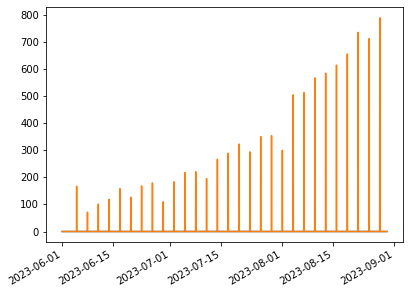

In [14]:
log['forecastpv']['duration'].plot()
log['trainerpv']['duration'].plot()

In [15]:
print(log['getweather']['logging'].iloc[-1])

Done.


### Plotting

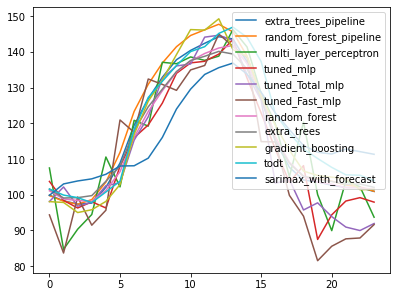

In [16]:
self = mgc.controller['forecastpv']['fun']
preds = {}
for fc in self.framework.fcData.iterrows():
    X = self.trainingData['X'].iloc[-1:].copy()
    X.loc[X.index, 'obs_y'] = self.trainingData['y'].loc[X.index] # add current y to obs
    X = self.framework.add_index_features(X) # add index features to obs
    preds[fc[1]['name']] = pd.DataFrame(fc[1]['model'].predict(X)).transpose()[0]
    if preds[fc[1]['name']].abs().max() < 1e6:
        plt.plot(preds[fc[1]['name']], label=fc[1]['name'])
    else:
        print(f'WARNING: Model {fc[1]["name"]} poor performance.')

plt.legend(loc=1)
plt.show()

preds = pd.DataFrame(preds)

In [17]:
# preds

In [18]:
if len(trainingResults) > 0:
    trainingResults.reverse()
    for it, t in enumerate(trainingResults):
        tt = pd.read_json(t)
        if len(tt) > 1:
            break
    pd.read_json(trainingResults[it])

In [19]:
log['forecastpv']['model-summary'].apply(lambda x: x['bestScoreRmse'] if 'bestScoreRmse' in x.keys() else np.nan).plot()
plt.show()

AttributeError: 'float' object has no attribute 'keys'

In [ ]:
# log['forecastpv']

In [ ]:
# log['forecastload']

In [ ]:
for t in log['forecastpv']['logging'].unique():
    if 'error' in t.lower():
        print(t)

In [ ]:
status_map = {k:0 if k=='Done.' else 1 if k=='WARNING: Externally trained model not yet avialable. No prediction generated.' else 2 for k in log['forecastpv']['logging'].unique()}
log['forecastpv']['logging'].replace(status_map).plot(title='Prediction Output', \
    ylabel='Init = 1; Ok = 0; Error = 2')

status_map = {k:0 if k=='Done.' else 1 if k=='WARNING: Externally trained model not yet avialable. No prediction generated.' else 2 for k in log['forecastload']['logging'].unique()}
log['forecastload']['logging'].replace(status_map).plot(title='Prediction Output', \
    ylabel='Init = 1; Ok = 0; Error = 2')
plt.show()

In [ ]:
log['forecastpv']['duration'].plot()

In [ ]:
for fc in log['forecastpv']['output-data'].values:
    if isinstance(fc, (str)):
        pd.read_json(fc)['y'].plot()
plt.show()

for fc in log['forecastload']['output-data'].values:
    if isinstance(fc, (str)):
        pd.read_json(fc)['y'].plot()
plt.show()